In [1]:
import torch
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import math
from scipy import ndimage


In [2]:
from model_lcrn import LRCN
from model_seq_cnn import SequentialCNN
from model_trainer import train_model
from data_loader import VideoDataset
import data_utils
from pprint import pprint
import data_def
import metrics

In [3]:
# np array with shape (frames, height, width, channels)

def show_video(video, start=0, end=25):
    span = math.ceil(math.sqrt(end - start))
    plt.figure(figsize=(20, 10))
    _, vH, vW = video[0].shape
    H, W = vH * span, vW * span
    grid = np.zeros((H, W, 3))
    for idx in range(start, end):
        r, c = (idx - start) // span, (idx - start) % span
        frame = video[idx]
        frame = np.moveaxis(frame, 0, -1).copy()
        if frame.shape[2] == 3: # if not grayscale, switch R and B
            ch2 = frame[:, :, 2].copy()
            frame[:, :, 2] = frame[:, :, 0]
            frame[:, :, 0] = ch2
        grid[r * vH : (r + 1) * vH, c * vW : (c + 1) * vW] = frame
    plt.imshow(grid.astype('uint8'))

### Preparation
We build a custom dataloader. It will return a new sample clip drawn uniformly from all possible clips of L frames from all the videos combined.


In [4]:
video_dataset = VideoDataset(
        '../data/video_small',
        '../data/label_aligned',
        clip_length=30,
        verbose_init=True,
        label_conversion_func=data_def.sparse_to_expanded_array,
        video_filenames=['kevin_random_moves_quick.mp4']
    )

VideoDataset __init__
clip_length: 30
frame size: 68 x 90
video files:
['kevin_random_moves_quick.mp4']


Now let's display the frames:

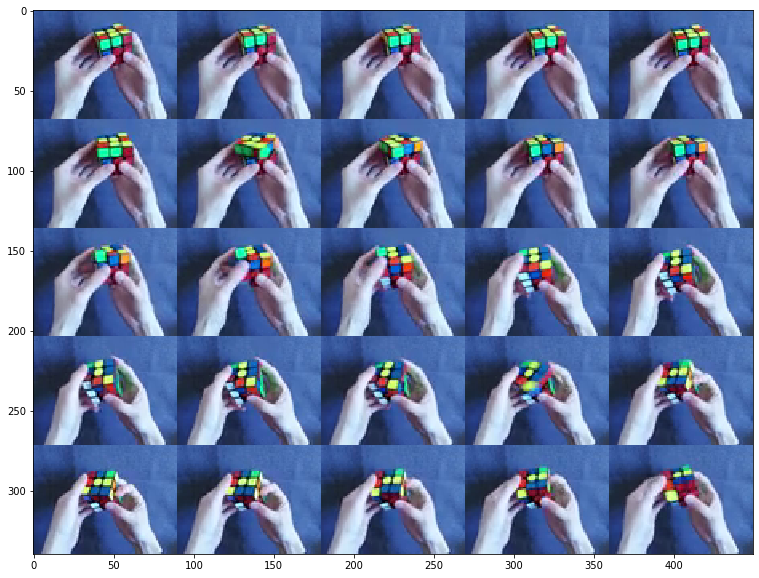

In [5]:
show_video(video_dataset[0][0])

In [6]:
torch.cuda.is_available()

False

## Baseline Model

Now it's time to build our model based on the paper "A Fast Statistical Approach for Human Activity Recognition". We take the delta frames and calculate the scalar features. Then we'll pass these features to a simple RNN. We will include the preprocess step by extending the dataloader, and we will use a LSTM with FC layer for the model.

In [7]:
def preprocess(video):
    #video = dataset[0]
    #print(video[0].shape)
    diff_video = np.abs(np.diff(video, axis=0))
    F, C, H, W = diff_video.shape

    diff_video_t = diff_video.transpose((0, 1, 3, 2))
    X_center_of_mass = np.sum(diff_video * np.arange(W), axis=(2, 3))  \
                               / np.sum(diff_video, axis=(2, 3))
    Y_center_of_mass = np.sum(diff_video_t * np.arange(H), axis=(2, 3))  \
                               / np.sum(diff_video_t, axis=(2, 3))

    X_mean_abs_dev = np.sum( (diff_video - X_center_of_mass.reshape(F, C, 1, 1)) * np.arange(W), axis=(2, 3))  \
                               / np.sum(diff_video, axis=(2, 3))
    Y_mean_abs_dev = np.sum( (diff_video_t - Y_center_of_mass.reshape(F, C, 1, 1)) * np.arange(H), axis=(2, 3))  \
                               / np.sum(diff_video_t, axis=(2, 3))

    intensity = np.mean(diff_video, axis=(2, 3))
    return np.stack((X_center_of_mass, 
                     Y_center_of_mass, 
                     X_mean_abs_dev, 
                     Y_mean_abs_dev, 
                     intensity)
                    ,axis=-1)
    #print([ ndimage.measurements.center_of_mass(diff_video[i][0]) for i in range(20)])
    #diff_video = diff_video.reshape(F, 1, H, W)
    #show_video(diff_video)
    #print("total number of samples", dataset.len)

In [8]:
class BaselineVideoDataset(VideoDataset):
    def __getitem__(self, idx):
        x, y, l = super().__getitem__(idx)
        # TODO: maybe trim y[0] so that x and y dimension aligns ?
        return preprocess(x), y[1:], l - 1
        

In [9]:
B, L, C = 5, 30 + 1, data_utils.NUM_CHANNEL
train_files = [
            'kevin_random_moves_quick.mp4',
            'kevin_random_moves_quick_2.mp4',
            'kevin_random_moves_quick_3.mp4',
            'kevin_random_moves_quick_4.mp4',
            'kevin_random_moves_slow.mp4',
            'kevin_rotate_1.mp4',
            'kevin_simple_shuffle_1.mp4',
            'kevin_single_moves_2.mp4',
            'kevin_single_solve_1.mp4',
            'kevin_solve_play_1.mp4',
            'kevin_solve_play_10.mp4',
            'kevin_solve_play_11.mp4',
            'kevin_solve_play_12.mp4',
            'kevin_solve_play_13.mp4',
            'kevin_solve_play_2.mp4',
            'kevin_solve_play_3.mp4',
            'kevin_solve_play_6.mp4',
            'kevin_solve_play_7.mp4',
            'kevin_solve_play_8.mp4',
            'kevin_solve_play_9.mp4',
            'zhouheng_cfop_solve.mp4',
            'zhouheng_oll_algorithm.mp4',
            'zhouheng_pll_algorithm_fast.mp4',
            'zhouheng_rotation.mp4',
            'zhouheng_scramble_01.mp4',
            'zhouheng_scramble_03.mp4',
            'zhouheng_weird_turns.mp4',
        ]
dev_files = [
            'kevin_single_moves_1.mp4',
            'kevin_solve_play_5.mp4',
            'zhouheng_scramble_02.mp4',
        ]
train_dataset = BaselineVideoDataset(
        '../data/video_small',
        '../data/label_aligned',
        clip_length=L,
        verbose_init=True,
        label_conversion_func=data_def.sparse_to_expanded_array,
        video_filenames=train_files
    )
dev_dataset = BaselineVideoDataset(
        '../data/video_small',
        '../data/label_aligned',
        clip_length=L,
        verbose_init=True,
        label_conversion_func=data_def.sparse_to_expanded_array,
        video_filenames=dev_files
    )
H, W = train_dataset.frame_size()
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=B, num_workers=1,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=B, num_workers=1,
)

VideoDataset __init__
clip_length: 31
frame size: 68 x 90
video files:
['kevin_random_moves_quick.mp4',
 'kevin_random_moves_quick_2.mp4',
 'kevin_random_moves_quick_3.mp4',
 'kevin_random_moves_quick_4.mp4',
 'kevin_random_moves_slow.mp4',
 'kevin_rotate_1.mp4',
 'kevin_simple_shuffle_1.mp4',
 'kevin_single_moves_2.mp4',
 'kevin_single_solve_1.mp4',
 'kevin_solve_play_1.mp4',
 'kevin_solve_play_10.mp4',
 'kevin_solve_play_11.mp4',
 'kevin_solve_play_12.mp4',
 'kevin_solve_play_13.mp4',
 'kevin_solve_play_2.mp4',
 'kevin_solve_play_3.mp4',
 'kevin_solve_play_6.mp4',
 'kevin_solve_play_7.mp4',
 'kevin_solve_play_8.mp4',
 'kevin_solve_play_9.mp4',
 'zhouheng_cfop_solve.mp4',
 'zhouheng_oll_algorithm.mp4',
 'zhouheng_pll_algorithm_fast.mp4',
 'zhouheng_rotation.mp4',
 'zhouheng_scramble_01.mp4',
 'zhouheng_scramble_03.mp4',
 'zhouheng_weird_turns.mp4']
VideoDataset __init__
clip_length: 31
frame size: 68 x 90
video files:
['kevin_single_moves_1.mp4',
 'kevin_solve_play_5.mp4',
 'zhouheng_

Again, let's display some frames of the diff data:


In [14]:
class BaselinePredictor(torch.nn.Module):
    
    def __init__(self, lstm_hidden_size, lstm_num_layers, num_classes):
        super(BaselinePredictor, self).__init__()
        self.input_dim = input_dim = 5 * 3
        self.lstm_hidden_size = lstm_hidden_size
        self.num_classes = num_classes
        self.lstm = torch.nn.LSTM(
            input_size=input_dim,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            bias=True,
            batch_first=True,  # so that input is (B, L, input_dim)
            dropout=0,  # dont use dropout between lstm layers,
            bidirectional=False
        )
        self.fc = torch.nn.Linear(
            in_features=lstm_hidden_size,
            out_features=num_classes,
            bias=True
        )
        self.prev_lstm_state = None
        
    def forward(self, x, use_prev_lstm_state=False):
        lstm_state = self.prev_lstm_state if use_prev_lstm_state else None
        x = x.reshape(B, L - 1, self.input_dim)
        x, self.prev_lstm_state = self.lstm(x, lstm_state)
        x = x.reshape(B * (L - 1), self.lstm_hidden_size)
        # x=(B * L, lstm_hidden_size)
        x = self.fc(x)
        x = x.reshape(B, (L - 1), self.num_classes)
        
        return x
        

In [15]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [16]:
print(train_dataset[0][0].shape)

(30, 3, 5)


In [17]:
pprint(train_dataset.get_label_counts())

model = BaselinePredictor(
    lstm_hidden_size=20,
    lstm_num_layers=2,
    num_classes=train_dataset.num_class(),
)
print(model)

optimizer = torch.optim.Adam(model.parameters())

def on_batch(i, x, y, scores):
    if i % 10 == 0:
        # print(y.shape)
        # print(scores.shape)
        yhat = torch.argmax(scores[0], dim=-1).cpu().numpy()
        # yhat_collapsed = data_def.to_collapsed_string_list(yhat)
        # y_collapsed = data_def.to_collapsed_string_list(y[0].cpu().numpy())
        # print(yhat_collapsed)
        # print(y_collapsed)
        print()
        # data_utils.array_to_video_view(
        #     x[0].cpu().numpy(), y[0].cpu().numpy())
        print(yhat)
        print(y[0].cpu().numpy())
        print('mean edit dist')
        print(metrics.sum_edit_distance(scores, y) / len(y))

results = train_model(
    model,
    train_dataloader=train_loader,
    optimizer=optimizer,
    criterion_name='cross_entropy',
    #dev_dataloader=dev_loader,
    # test_dataloader=dev_loader,
    num_epoch=1,
    on_batch=on_batch,
    additional_metrics={
        'edit_distance': metrics.sum_edit_distance
    }
)

print(results)


EPOCH:   0%|          | 0/1 [00:00<?, ?it/s]

train:   0%|          | 0/1022 [00:00<?, ?it/s]

{'B': 117,
 "B'": 92,
 'D': 393,
 "D'": 274,
 'F': 279,
 "F'": 277,
 'L': 1016,
 "L'": 317,
 'R': 1689,
 "R'": 1075,
 'U': 2686,
 "U'": 1121,
 '_': 152375,
 'x': 246,
 "x'": 354,
 'x2': 7,
 'y': 414,
 "y'": 299,
 'z': 79,
 "z'": 214,
 'z2': 4}
BaselinePredictor(
  (lstm): LSTM(15, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=22, bias=True)
)
Starting train, best_dev_loss=[inf]




train:   0%|          | 1/1022 [00:00<07:37,  2.23it/s]


[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 11]
mean edit dist
2.0




train:   0%|          | 2/1022 [00:00<07:26,  2.29it/s]

train:   0%|          | 3/1022 [00:01<07:17,  2.33it/s]

train:   0%|          | 4/1022 [00:01<07:04,  2.40it/s]

train:   0%|          | 5/1022 [00:02<07:04,  2.39it/s]

train:   1%|          | 6/1022 [00:02<06:57,  2.43it/s]

train:   1%|          | 7/1022 [00:02<06:58,  2.43it/s]

train:   1%|          | 8/1022 [00:03<06:57,  2.43it/s]

train:   1%|          | 9/1022 [00:03<06:50,  2.47it/s]

train:   1%|          | 10/1022 [00:04<06:49,  2.47it/s]

train:   1%|          | 11/1022 [00:04<06:49,  2.47it/s]


[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4]
[ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12
  0  0  0  0  0  0]
mean edit dist
1.8




train:   1%|          | 12/1022 [00:04<06:46,  2.49it/s]

train:   1%|▏         | 13/1022 [00:05<06:53,  2.44it/s]

train:   1%|▏         | 14/1022 [00:05<06:56,  2.42it/s]

train:   1%|▏         | 15/1022 [00:06<06:52,  2.44it/s]

train:   2%|▏         | 16/1022 [00:06<06:56,  2.42it/s]

train:   2%|▏         | 17/1022 [00:06<06:57,  2.41it/s]

train:   2%|▏         | 18/1022 [00:07<06:54,  2.42it/s]

train:   2%|▏         | 19/1022 [00:07<06:57,  2.40it/s]

train:   2%|▏         | 20/1022 [00:08<07:00,  2.39it/s]

train:   2%|▏         | 21/1022 [00:08<06:59,  2.39it/s]


[4 4 4 4 4 4 4 4 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0
 14  0  0  0  0  0]
mean edit dist
3.0




train:   2%|▏         | 22/1022 [00:09<07:00,  2.38it/s]

train:   2%|▏         | 23/1022 [00:09<06:53,  2.42it/s]

train:   2%|▏         | 24/1022 [00:09<06:57,  2.39it/s]

train:   2%|▏         | 25/1022 [00:10<06:55,  2.40it/s]

train:   3%|▎         | 26/1022 [00:10<06:56,  2.39it/s]

train:   3%|▎         | 27/1022 [00:11<06:55,  2.40it/s]

train:   3%|▎         | 28/1022 [00:11<06:55,  2.39it/s]

train:   3%|▎         | 29/1022 [00:12<06:55,  2.39it/s]

train:   3%|▎         | 30/1022 [00:12<07:00,  2.36it/s]

train:   3%|▎         | 31/1022 [00:12<06:55,  2.38it/s]


[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  2  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0 12  0  0  0
  0  0  0  0  0 14]
mean edit dist
2.8




train:   3%|▎         | 32/1022 [00:13<06:54,  2.39it/s]

train:   3%|▎         | 33/1022 [00:13<06:53,  2.39it/s]

train:   3%|▎         | 34/1022 [00:14<06:51,  2.40it/s]

train:   3%|▎         | 35/1022 [00:14<06:53,  2.39it/s]

train:   4%|▎         | 36/1022 [00:14<06:56,  2.37it/s]

train:   4%|▎         | 37/1022 [00:15<06:54,  2.38it/s]

train:   4%|▎         | 38/1022 [00:15<06:58,  2.35it/s]

train:   4%|▍         | 39/1022 [00:16<06:51,  2.39it/s]

train:   4%|▍         | 40/1022 [00:16<06:50,  2.39it/s]

train:   4%|▍         | 41/1022 [00:17<06:53,  2.37it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
mean edit dist
2.6




train:   4%|▍         | 42/1022 [00:17<06:50,  2.39it/s]

train:   4%|▍         | 43/1022 [00:17<06:38,  2.46it/s]

train:   4%|▍         | 44/1022 [00:18<06:39,  2.45it/s]

train:   4%|▍         | 45/1022 [00:18<06:37,  2.46it/s]

train:   5%|▍         | 46/1022 [00:19<06:39,  2.44it/s]

train:   5%|▍         | 47/1022 [00:19<06:44,  2.41it/s]

train:   5%|▍         | 48/1022 [00:19<06:46,  2.40it/s]

train:   5%|▍         | 49/1022 [00:20<06:45,  2.40it/s]

train:   5%|▍         | 50/1022 [00:20<06:50,  2.37it/s]

train:   5%|▍         | 51/1022 [00:21<06:52,  2.35it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
1.4




train:   5%|▌         | 52/1022 [00:21<06:49,  2.37it/s]

train:   5%|▌         | 53/1022 [00:22<06:52,  2.35it/s]

train:   5%|▌         | 54/1022 [00:22<06:43,  2.40it/s]

train:   5%|▌         | 55/1022 [00:22<06:41,  2.41it/s]

train:   5%|▌         | 56/1022 [00:23<06:34,  2.45it/s]

train:   6%|▌         | 57/1022 [00:23<06:42,  2.40it/s]

train:   6%|▌         | 58/1022 [00:24<06:44,  2.39it/s]

train:   6%|▌         | 59/1022 [00:24<07:00,  2.29it/s]

train:   6%|▌         | 60/1022 [00:25<06:52,  2.33it/s]

train:   6%|▌         | 61/1022 [00:25<06:53,  2.32it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 12 12  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
1.6




train:   6%|▌         | 62/1022 [00:25<06:50,  2.34it/s]

train:   6%|▌         | 63/1022 [00:26<06:47,  2.35it/s]

train:   6%|▋         | 64/1022 [00:26<06:51,  2.33it/s]

train:   6%|▋         | 65/1022 [00:27<06:49,  2.34it/s]

train:   6%|▋         | 66/1022 [00:27<06:45,  2.36it/s]

train:   7%|▋         | 67/1022 [00:27<06:40,  2.39it/s]

train:   7%|▋         | 68/1022 [00:28<06:39,  2.39it/s]

train:   7%|▋         | 69/1022 [00:28<06:39,  2.39it/s]

train:   7%|▋         | 70/1022 [00:29<06:40,  2.38it/s]

train:   7%|▋         | 71/1022 [00:29<06:37,  2.39it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0 12 15  0  0  0  0  0  0  0 13  0  0  0  0 14
  0  0  0  0  0  0]
mean edit dist
2.2




train:   7%|▋         | 72/1022 [00:30<06:36,  2.40it/s]

train:   7%|▋         | 73/1022 [00:30<06:32,  2.42it/s]

train:   7%|▋         | 74/1022 [00:30<06:29,  2.44it/s]

train:   7%|▋         | 75/1022 [00:31<06:28,  2.44it/s]

train:   7%|▋         | 76/1022 [00:31<06:28,  2.44it/s]

train:   8%|▊         | 77/1022 [00:32<06:29,  2.43it/s]

train:   8%|▊         | 78/1022 [00:32<06:30,  2.42it/s]

train:   8%|▊         | 79/1022 [00:32<06:34,  2.39it/s]

train:   8%|▊         | 80/1022 [00:33<06:37,  2.37it/s]

train:   8%|▊         | 81/1022 [00:33<06:37,  2.37it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 11  0  0  0]
mean edit dist
2.6




train:   8%|▊         | 82/1022 [00:34<06:35,  2.37it/s]

train:   8%|▊         | 83/1022 [00:34<06:32,  2.39it/s]

train:   8%|▊         | 84/1022 [00:35<06:29,  2.41it/s]

train:   8%|▊         | 85/1022 [00:35<06:29,  2.41it/s]

train:   8%|▊         | 86/1022 [00:35<06:26,  2.42it/s]

train:   9%|▊         | 87/1022 [00:36<06:31,  2.39it/s]

train:   9%|▊         | 88/1022 [00:36<06:29,  2.40it/s]

train:   9%|▊         | 89/1022 [00:37<06:29,  2.39it/s]

train:   9%|▉         | 90/1022 [00:37<06:25,  2.42it/s]

train:   9%|▉         | 91/1022 [00:37<06:31,  2.38it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.0




train:   9%|▉         | 92/1022 [00:38<06:24,  2.42it/s]

train:   9%|▉         | 93/1022 [00:38<06:27,  2.40it/s]

train:   9%|▉         | 94/1022 [00:39<06:28,  2.39it/s]

train:   9%|▉         | 95/1022 [00:39<06:32,  2.36it/s]

train:   9%|▉         | 96/1022 [00:40<06:25,  2.40it/s]

train:   9%|▉         | 97/1022 [00:40<06:26,  2.40it/s]

train:  10%|▉         | 98/1022 [00:40<06:24,  2.40it/s]

train:  10%|▉         | 99/1022 [00:41<06:30,  2.37it/s]

train:  10%|▉         | 100/1022 [00:41<06:25,  2.39it/s]

train:  10%|▉         | 101/1022 [00:42<06:23,  2.40it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0
  0  0  0 10  0  0]
mean edit dist
1.8




train:  10%|▉         | 102/1022 [00:42<06:25,  2.39it/s]

train:  10%|█         | 103/1022 [00:42<06:21,  2.41it/s]

train:  10%|█         | 104/1022 [00:43<06:19,  2.42it/s]

train:  10%|█         | 105/1022 [00:43<06:22,  2.40it/s]

train:  10%|█         | 106/1022 [00:44<06:24,  2.38it/s]

train:  10%|█         | 107/1022 [00:44<06:24,  2.38it/s]

train:  11%|█         | 108/1022 [00:45<06:23,  2.38it/s]

train:  11%|█         | 109/1022 [00:45<06:26,  2.36it/s]/Users/i_love_bianka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/i_love_bianka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


train:  11%|█         | 110/1022 [00:45<06:34,  2.31it/s]

train:  11%|█         | 111/1022 [00:46<06:28,  2.34it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 10  0]
mean edit dist
1.8




train:  11%|█         | 112/1022 [00:46<06:30,  2.33it/s]

train:  11%|█         | 113/1022 [00:47<06:25,  2.36it/s]

train:  11%|█         | 114/1022 [00:47<06:23,  2.37it/s]

train:  11%|█▏        | 115/1022 [00:48<06:19,  2.39it/s]

train:  11%|█▏        | 116/1022 [00:48<06:21,  2.37it/s]

train:  11%|█▏        | 117/1022 [00:48<06:24,  2.36it/s]

train:  12%|█▏        | 118/1022 [00:49<06:26,  2.34it/s]

train:  12%|█▏        | 119/1022 [00:49<06:29,  2.32it/s]

train:  12%|█▏        | 120/1022 [00:50<06:25,  2.34it/s]

train:  12%|█▏        | 121/1022 [00:50<06:28,  2.32it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
1.4




train:  12%|█▏        | 122/1022 [00:51<06:57,  2.16it/s]

train:  12%|█▏        | 123/1022 [00:51<06:47,  2.21it/s]

train:  12%|█▏        | 124/1022 [00:52<06:37,  2.26it/s]

train:  12%|█▏        | 125/1022 [00:52<06:28,  2.31it/s]

train:  12%|█▏        | 126/1022 [00:52<06:22,  2.34it/s]

train:  12%|█▏        | 127/1022 [00:53<06:40,  2.23it/s]

train:  13%|█▎        | 128/1022 [00:53<06:36,  2.26it/s]

train:  13%|█▎        | 129/1022 [00:54<06:34,  2.26it/s]

train:  13%|█▎        | 130/1022 [00:54<06:40,  2.23it/s]

train:  13%|█▎        | 131/1022 [00:55<06:38,  2.24it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0
 15  0  0  0  0  0]
mean edit dist
2.8




train:  13%|█▎        | 132/1022 [00:55<06:28,  2.29it/s]

train:  13%|█▎        | 133/1022 [00:55<06:26,  2.30it/s]

train:  13%|█▎        | 134/1022 [00:56<06:24,  2.31it/s]

train:  13%|█▎        | 135/1022 [00:56<06:26,  2.30it/s]

train:  13%|█▎        | 136/1022 [00:57<06:26,  2.29it/s]

train:  13%|█▎        | 137/1022 [00:57<06:23,  2.31it/s]

train:  14%|█▎        | 138/1022 [00:58<06:21,  2.32it/s]

train:  14%|█▎        | 139/1022 [00:58<06:21,  2.32it/s]

train:  14%|█▎        | 140/1022 [00:58<06:20,  2.32it/s]

train:  14%|█▍        | 141/1022 [00:59<06:21,  2.31it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0 12  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.0




train:  14%|█▍        | 142/1022 [00:59<06:23,  2.29it/s]

train:  14%|█▍        | 143/1022 [01:00<06:17,  2.33it/s]

train:  14%|█▍        | 144/1022 [01:00<06:26,  2.27it/s]

train:  14%|█▍        | 145/1022 [01:01<06:22,  2.29it/s]

train:  14%|█▍        | 146/1022 [01:01<06:21,  2.30it/s]

train:  14%|█▍        | 147/1022 [01:02<06:19,  2.30it/s]

train:  14%|█▍        | 148/1022 [01:02<06:15,  2.33it/s]

train:  15%|█▍        | 149/1022 [01:02<06:15,  2.33it/s]

train:  15%|█▍        | 150/1022 [01:03<06:26,  2.25it/s]

train:  15%|█▍        | 151/1022 [01:03<06:43,  2.16it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0
  0  0  0  0  0 14]
mean edit dist
1.4




train:  15%|█▍        | 152/1022 [01:04<06:32,  2.22it/s]

train:  15%|█▍        | 153/1022 [01:04<06:18,  2.30it/s]

train:  15%|█▌        | 154/1022 [01:05<06:16,  2.31it/s]

train:  15%|█▌        | 155/1022 [01:05<06:18,  2.29it/s]

train:  15%|█▌        | 156/1022 [01:05<06:11,  2.33it/s]

train:  15%|█▌        | 157/1022 [01:06<06:11,  2.33it/s]

train:  15%|█▌        | 158/1022 [01:06<06:16,  2.29it/s]

train:  16%|█▌        | 159/1022 [01:07<06:20,  2.27it/s]

train:  16%|█▌        | 160/1022 [01:07<06:23,  2.25it/s]

train:  16%|█▌        | 161/1022 [01:08<06:24,  2.24it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 12  0  0  0  0  0]
mean edit dist
2.2




train:  16%|█▌        | 162/1022 [01:08<06:20,  2.26it/s]

train:  16%|█▌        | 163/1022 [01:09<06:18,  2.27it/s]

train:  16%|█▌        | 164/1022 [01:09<06:12,  2.30it/s]

train:  16%|█▌        | 165/1022 [01:09<06:08,  2.33it/s]

train:  16%|█▌        | 166/1022 [01:10<06:09,  2.32it/s]

train:  16%|█▋        | 167/1022 [01:10<06:04,  2.34it/s]

train:  16%|█▋        | 168/1022 [01:11<06:05,  2.34it/s]

train:  17%|█▋        | 169/1022 [01:11<06:04,  2.34it/s]

train:  17%|█▋        | 170/1022 [01:12<05:58,  2.38it/s]

train:  17%|█▋        | 171/1022 [01:12<05:58,  2.37it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0 13  0  0  0  0  0
  0  0  0 18  0  0]
mean edit dist
2.0




train:  17%|█▋        | 172/1022 [01:12<06:00,  2.36it/s]

train:  17%|█▋        | 173/1022 [01:13<06:05,  2.33it/s]

train:  17%|█▋        | 174/1022 [01:13<06:06,  2.31it/s]

train:  17%|█▋        | 175/1022 [01:14<05:59,  2.36it/s]

train:  17%|█▋        | 176/1022 [01:14<05:55,  2.38it/s]

train:  17%|█▋        | 177/1022 [01:15<05:53,  2.39it/s]

train:  17%|█▋        | 178/1022 [01:15<05:47,  2.43it/s]

train:  18%|█▊        | 179/1022 [01:15<05:55,  2.37it/s]

train:  18%|█▊        | 180/1022 [01:16<05:55,  2.37it/s]

train:  18%|█▊        | 181/1022 [01:16<05:51,  2.39it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[12  0  0  0  0 14  0  0  0  0 13  0  0  0 16  0  0  0  0  0  0  0  0 12
  0  0  0 15  0  0]
mean edit dist
1.8




train:  18%|█▊        | 182/1022 [01:17<05:50,  2.40it/s]

train:  18%|█▊        | 183/1022 [01:17<05:43,  2.44it/s]

train:  18%|█▊        | 184/1022 [01:17<05:49,  2.39it/s]

train:  18%|█▊        | 185/1022 [01:18<05:53,  2.37it/s]

train:  18%|█▊        | 186/1022 [01:18<05:48,  2.40it/s]

train:  18%|█▊        | 187/1022 [01:19<05:48,  2.40it/s]

train:  18%|█▊        | 188/1022 [01:19<05:50,  2.38it/s]

train:  18%|█▊        | 189/1022 [01:20<05:51,  2.37it/s]

train:  19%|█▊        | 190/1022 [01:20<05:51,  2.37it/s]

train:  19%|█▊        | 191/1022 [01:20<05:52,  2.36it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
2.0




train:  19%|█▉        | 192/1022 [01:21<05:53,  2.35it/s]

train:  19%|█▉        | 193/1022 [01:21<05:49,  2.37it/s]

train:  19%|█▉        | 194/1022 [01:22<05:42,  2.42it/s]

train:  19%|█▉        | 195/1022 [01:22<05:42,  2.41it/s]

train:  19%|█▉        | 196/1022 [01:22<05:47,  2.38it/s]

train:  19%|█▉        | 197/1022 [01:23<05:54,  2.33it/s]

train:  19%|█▉        | 198/1022 [01:23<05:52,  2.33it/s]

train:  19%|█▉        | 199/1022 [01:24<05:52,  2.33it/s]

train:  20%|█▉        | 200/1022 [01:24<05:49,  2.35it/s]

train:  20%|█▉        | 201/1022 [01:25<05:46,  2.37it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0 15  0  0  0  0 12  0  0  0 14  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.2




train:  20%|█▉        | 202/1022 [01:25<05:42,  2.39it/s]

train:  20%|█▉        | 203/1022 [01:25<05:39,  2.41it/s]

train:  20%|█▉        | 204/1022 [01:26<05:43,  2.38it/s]

train:  20%|██        | 205/1022 [01:26<05:42,  2.39it/s]

train:  20%|██        | 206/1022 [01:27<05:47,  2.35it/s]

train:  20%|██        | 207/1022 [01:27<05:42,  2.38it/s]

train:  20%|██        | 208/1022 [01:28<05:39,  2.39it/s]

train:  20%|██        | 209/1022 [01:28<05:40,  2.39it/s]

train:  21%|██        | 210/1022 [01:28<05:42,  2.37it/s]

train:  21%|██        | 211/1022 [01:29<05:48,  2.33it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 14]
mean edit dist
2.0




train:  21%|██        | 212/1022 [01:29<05:48,  2.32it/s]

train:  21%|██        | 213/1022 [01:30<05:47,  2.33it/s]

train:  21%|██        | 214/1022 [01:30<05:46,  2.33it/s]

train:  21%|██        | 215/1022 [01:31<05:46,  2.33it/s]

train:  21%|██        | 216/1022 [01:31<05:38,  2.38it/s]

train:  21%|██        | 217/1022 [01:31<05:43,  2.34it/s]

train:  21%|██▏       | 218/1022 [01:32<05:40,  2.36it/s]

train:  21%|██▏       | 219/1022 [01:32<05:40,  2.36it/s]

train:  22%|██▏       | 220/1022 [01:33<05:37,  2.37it/s]

train:  22%|██▏       | 221/1022 [01:33<05:36,  2.38it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  0
  0  0 13  0  0  0]
mean edit dist
2.0




train:  22%|██▏       | 222/1022 [01:33<05:39,  2.36it/s]

train:  22%|██▏       | 223/1022 [01:34<05:37,  2.37it/s]

train:  22%|██▏       | 224/1022 [01:34<05:41,  2.34it/s]

train:  22%|██▏       | 225/1022 [01:35<05:42,  2.32it/s]

train:  22%|██▏       | 226/1022 [01:35<05:41,  2.33it/s]

train:  22%|██▏       | 227/1022 [01:36<05:36,  2.36it/s]

train:  22%|██▏       | 228/1022 [01:36<05:27,  2.43it/s]

train:  22%|██▏       | 229/1022 [01:36<05:33,  2.38it/s]

train:  23%|██▎       | 230/1022 [01:37<05:28,  2.41it/s]

train:  23%|██▎       | 231/1022 [01:37<05:31,  2.39it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0 19  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.2




train:  23%|██▎       | 232/1022 [01:38<05:22,  2.45it/s]

train:  23%|██▎       | 233/1022 [01:38<05:28,  2.40it/s]

train:  23%|██▎       | 234/1022 [01:39<05:33,  2.36it/s]

train:  23%|██▎       | 235/1022 [01:39<05:29,  2.39it/s]

train:  23%|██▎       | 236/1022 [01:39<05:33,  2.36it/s]

train:  23%|██▎       | 237/1022 [01:40<05:27,  2.39it/s]

train:  23%|██▎       | 238/1022 [01:40<05:29,  2.38it/s]

train:  23%|██▎       | 239/1022 [01:41<05:28,  2.38it/s]

train:  23%|██▎       | 240/1022 [01:41<05:29,  2.37it/s]

train:  24%|██▎       | 241/1022 [01:41<05:25,  2.40it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0
  0  0 16  0  0  0]
mean edit dist
2.0




train:  24%|██▎       | 242/1022 [01:42<05:18,  2.45it/s]

train:  24%|██▍       | 243/1022 [01:42<05:22,  2.41it/s]

train:  24%|██▍       | 244/1022 [01:43<05:26,  2.39it/s]

train:  24%|██▍       | 245/1022 [01:43<05:22,  2.41it/s]

train:  24%|██▍       | 246/1022 [01:44<05:18,  2.44it/s]

train:  24%|██▍       | 247/1022 [01:44<05:24,  2.39it/s]

train:  24%|██▍       | 248/1022 [01:44<05:23,  2.39it/s]

train:  24%|██▍       | 249/1022 [01:45<05:25,  2.38it/s]

train:  24%|██▍       | 250/1022 [01:45<05:26,  2.37it/s]

train:  25%|██▍       | 251/1022 [01:46<05:23,  2.38it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
1.4




train:  25%|██▍       | 252/1022 [01:46<05:14,  2.45it/s]

train:  25%|██▍       | 253/1022 [01:46<05:17,  2.42it/s]

train:  25%|██▍       | 254/1022 [01:47<05:16,  2.43it/s]

train:  25%|██▍       | 255/1022 [01:47<05:25,  2.36it/s]

train:  25%|██▌       | 256/1022 [01:48<05:22,  2.37it/s]

train:  25%|██▌       | 257/1022 [01:48<05:18,  2.40it/s]

train:  25%|██▌       | 258/1022 [01:49<05:20,  2.39it/s]

train:  25%|██▌       | 259/1022 [01:49<05:38,  2.25it/s]

train:  25%|██▌       | 260/1022 [01:49<05:34,  2.28it/s]

train:  26%|██▌       | 261/1022 [01:50<05:27,  2.32it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0 14  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0 12 15  0
  0  0  0  0  0  0]
mean edit dist
2.6




train:  26%|██▌       | 262/1022 [01:50<05:22,  2.36it/s]

train:  26%|██▌       | 263/1022 [01:51<05:20,  2.37it/s]

train:  26%|██▌       | 264/1022 [01:51<05:16,  2.39it/s]

train:  26%|██▌       | 265/1022 [01:52<05:21,  2.35it/s]

train:  26%|██▌       | 266/1022 [01:52<05:18,  2.38it/s]

train:  26%|██▌       | 267/1022 [01:52<05:19,  2.36it/s]

train:  26%|██▌       | 268/1022 [01:53<05:13,  2.40it/s]

train:  26%|██▋       | 269/1022 [01:53<05:13,  2.40it/s]

train:  26%|██▋       | 270/1022 [01:54<05:14,  2.39it/s]

train:  27%|██▋       | 271/1022 [01:54<05:15,  2.38it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.8




train:  27%|██▋       | 272/1022 [01:54<05:14,  2.38it/s]

train:  27%|██▋       | 273/1022 [01:55<05:06,  2.45it/s]

train:  27%|██▋       | 274/1022 [01:55<05:07,  2.43it/s]

train:  27%|██▋       | 275/1022 [01:56<05:07,  2.43it/s]

train:  27%|██▋       | 276/1022 [01:56<05:05,  2.44it/s]

train:  27%|██▋       | 277/1022 [01:57<05:03,  2.46it/s]

train:  27%|██▋       | 278/1022 [01:57<05:02,  2.46it/s]

train:  27%|██▋       | 279/1022 [01:57<05:04,  2.44it/s]

train:  27%|██▋       | 280/1022 [01:58<05:06,  2.42it/s]

train:  27%|██▋       | 281/1022 [01:58<05:14,  2.35it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0
  0  0 13  0  0  0]
mean edit dist
1.8




train:  28%|██▊       | 282/1022 [01:59<05:08,  2.40it/s]

train:  28%|██▊       | 283/1022 [01:59<05:07,  2.40it/s]

train:  28%|██▊       | 284/1022 [01:59<05:04,  2.43it/s]

train:  28%|██▊       | 285/1022 [02:00<05:02,  2.44it/s]

train:  28%|██▊       | 286/1022 [02:00<05:00,  2.45it/s]

train:  28%|██▊       | 287/1022 [02:01<05:05,  2.41it/s]

train:  28%|██▊       | 288/1022 [02:01<05:12,  2.35it/s]

train:  28%|██▊       | 289/1022 [02:02<05:11,  2.36it/s]

train:  28%|██▊       | 290/1022 [02:02<05:06,  2.39it/s]

train:  28%|██▊       | 291/1022 [02:02<05:04,  2.40it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
1.8




train:  29%|██▊       | 292/1022 [02:03<05:06,  2.38it/s]

train:  29%|██▊       | 293/1022 [02:03<04:59,  2.43it/s]

train:  29%|██▉       | 294/1022 [02:04<04:54,  2.47it/s]

train:  29%|██▉       | 295/1022 [02:04<04:55,  2.46it/s]

train:  29%|██▉       | 296/1022 [02:04<05:02,  2.40it/s]

train:  29%|██▉       | 297/1022 [02:05<05:00,  2.41it/s]

train:  29%|██▉       | 298/1022 [02:05<04:59,  2.42it/s]

train:  29%|██▉       | 299/1022 [02:06<04:58,  2.42it/s]

train:  29%|██▉       | 300/1022 [02:06<04:52,  2.47it/s]

train:  29%|██▉       | 301/1022 [02:06<04:58,  2.42it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 15  0]
mean edit dist
1.8




train:  30%|██▉       | 302/1022 [02:07<04:59,  2.40it/s]

train:  30%|██▉       | 303/1022 [02:07<04:51,  2.47it/s]

train:  30%|██▉       | 304/1022 [02:08<04:51,  2.46it/s]

train:  30%|██▉       | 305/1022 [02:08<04:52,  2.45it/s]

train:  30%|██▉       | 306/1022 [02:09<04:58,  2.40it/s]

train:  30%|███       | 307/1022 [02:09<05:00,  2.38it/s]

train:  30%|███       | 308/1022 [02:09<05:02,  2.36it/s]

train:  30%|███       | 309/1022 [02:10<04:58,  2.39it/s]

train:  30%|███       | 310/1022 [02:10<04:53,  2.42it/s]

train:  30%|███       | 311/1022 [02:11<04:57,  2.39it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
2.2




train:  31%|███       | 312/1022 [02:11<04:56,  2.40it/s]

train:  31%|███       | 313/1022 [02:11<04:56,  2.39it/s]

train:  31%|███       | 314/1022 [02:12<04:56,  2.39it/s]

train:  31%|███       | 315/1022 [02:12<04:54,  2.40it/s]

train:  31%|███       | 316/1022 [02:13<04:54,  2.39it/s]

train:  31%|███       | 317/1022 [02:13<04:54,  2.39it/s]

train:  31%|███       | 318/1022 [02:14<04:54,  2.39it/s]

train:  31%|███       | 319/1022 [02:14<05:07,  2.29it/s]

train:  31%|███▏      | 320/1022 [02:14<05:03,  2.31it/s]

train:  31%|███▏      | 321/1022 [02:15<05:00,  2.33it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
2.4




train:  32%|███▏      | 322/1022 [02:15<04:57,  2.35it/s]

train:  32%|███▏      | 323/1022 [02:16<04:54,  2.38it/s]

train:  32%|███▏      | 324/1022 [02:16<04:59,  2.33it/s]

train:  32%|███▏      | 325/1022 [02:17<05:00,  2.32it/s]

train:  32%|███▏      | 326/1022 [02:17<04:54,  2.37it/s]

train:  32%|███▏      | 327/1022 [02:17<04:52,  2.38it/s]

train:  32%|███▏      | 328/1022 [02:18<04:49,  2.40it/s]

train:  32%|███▏      | 329/1022 [02:18<04:44,  2.43it/s]

train:  32%|███▏      | 330/1022 [02:19<04:45,  2.42it/s]

train:  32%|███▏      | 331/1022 [02:19<04:40,  2.46it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
1.8




train:  32%|███▏      | 332/1022 [02:19<04:40,  2.46it/s]

train:  33%|███▎      | 333/1022 [02:20<04:42,  2.44it/s]

train:  33%|███▎      | 334/1022 [02:20<04:42,  2.43it/s]

train:  33%|███▎      | 335/1022 [02:21<04:43,  2.42it/s]

train:  33%|███▎      | 336/1022 [02:21<04:41,  2.43it/s]

train:  33%|███▎      | 337/1022 [02:21<04:40,  2.44it/s]

train:  33%|███▎      | 338/1022 [02:22<04:43,  2.42it/s]

train:  33%|███▎      | 339/1022 [02:22<04:42,  2.41it/s]

train:  33%|███▎      | 340/1022 [02:23<04:45,  2.39it/s]

train:  33%|███▎      | 341/1022 [02:23<04:47,  2.37it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12 12  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.2




train:  33%|███▎      | 342/1022 [02:24<04:41,  2.41it/s]

train:  34%|███▎      | 343/1022 [02:24<04:41,  2.42it/s]

train:  34%|███▎      | 344/1022 [02:24<04:53,  2.31it/s]

train:  34%|███▍      | 345/1022 [02:25<04:50,  2.33it/s]

train:  34%|███▍      | 346/1022 [02:25<04:48,  2.34it/s]

train:  34%|███▍      | 347/1022 [02:26<04:41,  2.40it/s]

train:  34%|███▍      | 348/1022 [02:26<04:36,  2.44it/s]

train:  34%|███▍      | 349/1022 [02:26<04:35,  2.44it/s]

train:  34%|███▍      | 350/1022 [02:27<04:41,  2.38it/s]

train:  34%|███▍      | 351/1022 [02:27<04:38,  2.41it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0 14  0  0  0  0  0
  0  0  0 12  0  0]
mean edit dist
2.4




train:  34%|███▍      | 352/1022 [02:28<04:34,  2.44it/s]

train:  35%|███▍      | 353/1022 [02:28<04:34,  2.43it/s]

train:  35%|███▍      | 354/1022 [02:29<04:29,  2.47it/s]

train:  35%|███▍      | 355/1022 [02:29<04:25,  2.51it/s]

train:  35%|███▍      | 356/1022 [02:29<04:28,  2.48it/s]

train:  35%|███▍      | 357/1022 [02:30<04:30,  2.46it/s]

train:  35%|███▌      | 358/1022 [02:30<04:28,  2.48it/s]

train:  35%|███▌      | 359/1022 [02:31<04:28,  2.47it/s]

train:  35%|███▌      | 360/1022 [02:31<04:27,  2.48it/s]

train:  35%|███▌      | 361/1022 [02:31<04:30,  2.45it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0 14  0  0  0 14  0  0  0  0  0  0  0  0 12  0
  0  0  0  0  0  0]
mean edit dist
1.6




train:  35%|███▌      | 362/1022 [02:32<04:30,  2.44it/s]

train:  36%|███▌      | 363/1022 [02:32<04:28,  2.45it/s]

train:  36%|███▌      | 364/1022 [02:33<04:29,  2.44it/s]

train:  36%|███▌      | 365/1022 [02:33<04:33,  2.40it/s]

train:  36%|███▌      | 366/1022 [02:33<04:31,  2.42it/s]

train:  36%|███▌      | 367/1022 [02:34<04:30,  2.42it/s]

train:  36%|███▌      | 368/1022 [02:34<04:30,  2.41it/s]

train:  36%|███▌      | 369/1022 [02:35<04:29,  2.42it/s]

train:  36%|███▌      | 370/1022 [02:35<04:32,  2.40it/s]

train:  36%|███▋      | 371/1022 [02:36<04:34,  2.37it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 8]
mean edit dist
1.4




train:  36%|███▋      | 372/1022 [02:36<04:31,  2.39it/s]

train:  36%|███▋      | 373/1022 [02:36<04:29,  2.41it/s]

train:  37%|███▋      | 374/1022 [02:37<04:30,  2.40it/s]

train:  37%|███▋      | 375/1022 [02:37<04:30,  2.39it/s]

train:  37%|███▋      | 376/1022 [02:38<04:28,  2.41it/s]

train:  37%|███▋      | 377/1022 [02:38<04:27,  2.41it/s]

train:  37%|███▋      | 378/1022 [02:38<04:30,  2.38it/s]

train:  37%|███▋      | 379/1022 [02:39<04:24,  2.43it/s]

train:  37%|███▋      | 380/1022 [02:39<04:22,  2.45it/s]

train:  37%|███▋      | 381/1022 [02:40<04:22,  2.44it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 17  0  0]
mean edit dist
1.8




train:  37%|███▋      | 382/1022 [02:40<04:30,  2.37it/s]

train:  37%|███▋      | 383/1022 [02:41<04:30,  2.36it/s]

train:  38%|███▊      | 384/1022 [02:41<04:29,  2.37it/s]

train:  38%|███▊      | 385/1022 [02:41<04:26,  2.39it/s]

train:  38%|███▊      | 386/1022 [02:42<04:22,  2.42it/s]

train:  38%|███▊      | 387/1022 [02:42<04:22,  2.42it/s]

train:  38%|███▊      | 388/1022 [02:43<04:24,  2.40it/s]

train:  38%|███▊      | 389/1022 [02:43<04:26,  2.38it/s]

train:  38%|███▊      | 390/1022 [02:43<04:22,  2.41it/s]

train:  38%|███▊      | 391/1022 [02:44<04:21,  2.41it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
1.6




train:  38%|███▊      | 392/1022 [02:44<04:20,  2.42it/s]

train:  38%|███▊      | 393/1022 [02:45<04:17,  2.45it/s]

train:  39%|███▊      | 394/1022 [02:45<04:25,  2.36it/s]

train:  39%|███▊      | 395/1022 [02:46<04:23,  2.38it/s]

train:  39%|███▊      | 396/1022 [02:46<04:23,  2.38it/s]

train:  39%|███▉      | 397/1022 [02:46<04:25,  2.35it/s]

train:  39%|███▉      | 398/1022 [02:47<04:27,  2.33it/s]

train:  39%|███▉      | 399/1022 [02:47<04:23,  2.36it/s]

train:  39%|███▉      | 400/1022 [02:48<04:17,  2.42it/s]

train:  39%|███▉      | 401/1022 [02:48<04:20,  2.38it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
1.8




train:  39%|███▉      | 402/1022 [02:49<04:22,  2.36it/s]

train:  39%|███▉      | 403/1022 [02:49<04:20,  2.38it/s]

train:  40%|███▉      | 404/1022 [02:49<04:22,  2.35it/s]

train:  40%|███▉      | 405/1022 [02:50<04:21,  2.36it/s]

train:  40%|███▉      | 406/1022 [02:50<04:17,  2.39it/s]

train:  40%|███▉      | 407/1022 [02:51<04:17,  2.39it/s]

train:  40%|███▉      | 408/1022 [02:51<04:16,  2.39it/s]

train:  40%|████      | 409/1022 [02:51<04:11,  2.43it/s]

train:  40%|████      | 410/1022 [02:52<04:12,  2.42it/s]

train:  40%|████      | 411/1022 [02:52<04:20,  2.34it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
1.4




train:  40%|████      | 412/1022 [02:53<04:18,  2.36it/s]

train:  40%|████      | 413/1022 [02:53<04:19,  2.34it/s]

train:  41%|████      | 414/1022 [02:54<04:16,  2.37it/s]

train:  41%|████      | 415/1022 [02:54<04:15,  2.38it/s]

train:  41%|████      | 416/1022 [02:54<04:11,  2.41it/s]

train:  41%|████      | 417/1022 [02:55<04:11,  2.41it/s]

train:  41%|████      | 418/1022 [02:55<04:12,  2.40it/s]

train:  41%|████      | 419/1022 [02:56<04:05,  2.45it/s]

train:  41%|████      | 420/1022 [02:56<04:08,  2.42it/s]

train:  41%|████      | 421/1022 [02:56<04:11,  2.39it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[15  0  0 12  0  0  0  0 14  0  0  0  0 13 15  0  0  0  0  0  0 12  0  0
  0  0 14  0  0  0]
mean edit dist
3.4




train:  41%|████▏     | 422/1022 [02:57<04:14,  2.36it/s]

train:  41%|████▏     | 423/1022 [02:57<04:15,  2.34it/s]

train:  41%|████▏     | 424/1022 [02:58<04:14,  2.35it/s]

train:  42%|████▏     | 425/1022 [02:58<04:18,  2.31it/s]

train:  42%|████▏     | 426/1022 [02:59<04:14,  2.34it/s]

train:  42%|████▏     | 427/1022 [02:59<04:09,  2.38it/s]

train:  42%|████▏     | 428/1022 [02:59<04:08,  2.39it/s]

train:  42%|████▏     | 429/1022 [03:00<04:07,  2.40it/s]

train:  42%|████▏     | 430/1022 [03:00<04:06,  2.40it/s]

train:  42%|████▏     | 431/1022 [03:01<04:08,  2.38it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0
  0  0  0  0  0  0]
mean edit dist
1.8




train:  42%|████▏     | 432/1022 [03:01<04:07,  2.38it/s]

train:  42%|████▏     | 433/1022 [03:02<04:07,  2.38it/s]

train:  42%|████▏     | 434/1022 [03:02<04:14,  2.31it/s]

train:  43%|████▎     | 435/1022 [03:02<04:11,  2.33it/s]

train:  43%|████▎     | 436/1022 [03:03<04:08,  2.35it/s]

train:  43%|████▎     | 437/1022 [03:03<04:06,  2.37it/s]

train:  43%|████▎     | 438/1022 [03:04<04:06,  2.37it/s]

train:  43%|████▎     | 439/1022 [03:04<04:11,  2.32it/s]

train:  43%|████▎     | 440/1022 [03:05<04:12,  2.30it/s]

train:  43%|████▎     | 441/1022 [03:05<04:20,  2.23it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
mean edit dist
2.2




train:  43%|████▎     | 442/1022 [03:05<04:14,  2.28it/s]

train:  43%|████▎     | 443/1022 [03:06<04:14,  2.27it/s]

train:  43%|████▎     | 444/1022 [03:06<04:17,  2.24it/s]

train:  44%|████▎     | 445/1022 [03:07<04:12,  2.29it/s]

train:  44%|████▎     | 446/1022 [03:07<04:06,  2.33it/s]

train:  44%|████▎     | 447/1022 [03:08<04:05,  2.34it/s]

train:  44%|████▍     | 448/1022 [03:08<04:05,  2.34it/s]

train:  44%|████▍     | 449/1022 [03:08<04:03,  2.36it/s]

train:  44%|████▍     | 450/1022 [03:09<03:58,  2.40it/s]

train:  44%|████▍     | 451/1022 [03:09<03:55,  2.43it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0 12  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0
  0 14  0  0  0  0]
mean edit dist
3.2




train:  44%|████▍     | 452/1022 [03:10<03:56,  2.41it/s]

train:  44%|████▍     | 453/1022 [03:10<03:55,  2.42it/s]

train:  44%|████▍     | 454/1022 [03:10<03:54,  2.42it/s]

train:  45%|████▍     | 455/1022 [03:11<03:55,  2.40it/s]

train:  45%|████▍     | 456/1022 [03:11<03:57,  2.39it/s]

train:  45%|████▍     | 457/1022 [03:12<03:55,  2.40it/s]

train:  45%|████▍     | 458/1022 [03:12<03:59,  2.35it/s]

train:  45%|████▍     | 459/1022 [03:13<03:59,  2.35it/s]

train:  45%|████▌     | 460/1022 [03:13<03:59,  2.35it/s]

train:  45%|████▌     | 461/1022 [03:13<03:58,  2.35it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
1.6




train:  45%|████▌     | 462/1022 [03:14<03:56,  2.37it/s]

train:  45%|████▌     | 463/1022 [03:14<03:57,  2.35it/s]

train:  45%|████▌     | 464/1022 [03:15<03:54,  2.38it/s]

train:  45%|████▌     | 465/1022 [03:15<03:52,  2.39it/s]

train:  46%|████▌     | 466/1022 [03:16<03:49,  2.42it/s]

train:  46%|████▌     | 467/1022 [03:16<03:50,  2.40it/s]

train:  46%|████▌     | 468/1022 [03:16<03:51,  2.39it/s]

train:  46%|████▌     | 469/1022 [03:17<03:53,  2.37it/s]

train:  46%|████▌     | 470/1022 [03:17<03:52,  2.38it/s]

train:  46%|████▌     | 471/1022 [03:18<03:49,  2.40it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 21  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.0




train:  46%|████▌     | 472/1022 [03:18<03:47,  2.42it/s]

train:  46%|████▋     | 473/1022 [03:18<03:44,  2.45it/s]

train:  46%|████▋     | 474/1022 [03:19<03:52,  2.35it/s]

train:  46%|████▋     | 475/1022 [03:19<03:53,  2.34it/s]

train:  47%|████▋     | 476/1022 [03:20<03:46,  2.41it/s]

train:  47%|████▋     | 477/1022 [03:20<03:44,  2.43it/s]

train:  47%|████▋     | 478/1022 [03:21<03:42,  2.45it/s]

train:  47%|████▋     | 479/1022 [03:21<03:45,  2.41it/s]

train:  47%|████▋     | 480/1022 [03:21<03:43,  2.43it/s]

train:  47%|████▋     | 481/1022 [03:22<03:42,  2.43it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18  0  0
  0  0  0  0  0  0]
mean edit dist
1.4




train:  47%|████▋     | 482/1022 [03:22<03:42,  2.43it/s]

train:  47%|████▋     | 483/1022 [03:23<03:39,  2.46it/s]

train:  47%|████▋     | 484/1022 [03:23<03:41,  2.43it/s]

train:  47%|████▋     | 485/1022 [03:23<03:41,  2.42it/s]

train:  48%|████▊     | 486/1022 [03:24<03:41,  2.42it/s]

train:  48%|████▊     | 487/1022 [03:24<03:42,  2.41it/s]

train:  48%|████▊     | 488/1022 [03:25<03:42,  2.40it/s]

train:  48%|████▊     | 489/1022 [03:25<03:42,  2.40it/s]

train:  48%|████▊     | 490/1022 [03:26<03:40,  2.42it/s]

train:  48%|████▊     | 491/1022 [03:26<03:41,  2.40it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
2.6




train:  48%|████▊     | 492/1022 [03:26<03:40,  2.41it/s]

train:  48%|████▊     | 493/1022 [03:27<03:38,  2.42it/s]

train:  48%|████▊     | 494/1022 [03:27<03:41,  2.39it/s]

train:  48%|████▊     | 495/1022 [03:28<03:39,  2.40it/s]

train:  49%|████▊     | 496/1022 [03:28<03:42,  2.36it/s]

train:  49%|████▊     | 497/1022 [03:28<03:41,  2.37it/s]

train:  49%|████▊     | 498/1022 [03:29<03:36,  2.42it/s]

train:  49%|████▉     | 499/1022 [03:29<03:34,  2.44it/s]

train:  49%|████▉     | 500/1022 [03:30<03:35,  2.42it/s]

train:  49%|████▉     | 501/1022 [03:30<03:33,  2.44it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11
  0  0  0  0  0  0]
mean edit dist
1.6




train:  49%|████▉     | 502/1022 [03:31<03:38,  2.38it/s]

train:  49%|████▉     | 503/1022 [03:31<03:35,  2.40it/s]

train:  49%|████▉     | 504/1022 [03:31<03:36,  2.39it/s]

train:  49%|████▉     | 505/1022 [03:32<03:32,  2.43it/s]

train:  50%|████▉     | 506/1022 [03:32<03:33,  2.41it/s]

train:  50%|████▉     | 507/1022 [03:33<03:32,  2.42it/s]

train:  50%|████▉     | 508/1022 [03:33<03:31,  2.43it/s]

train:  50%|████▉     | 509/1022 [03:33<03:28,  2.46it/s]

train:  50%|████▉     | 510/1022 [03:34<03:26,  2.48it/s]

train:  50%|█████     | 511/1022 [03:34<03:25,  2.48it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0 14  0  0  0 13  0  0  0 15  0  0  0  0 12  0  0  0  0 14 13  0  0
  0  0  0  0  0  0]
mean edit dist
2.4




train:  50%|█████     | 512/1022 [03:35<03:26,  2.47it/s]

train:  50%|█████     | 513/1022 [03:35<03:30,  2.42it/s]

train:  50%|█████     | 514/1022 [03:35<03:28,  2.43it/s]

train:  50%|█████     | 515/1022 [03:36<03:25,  2.47it/s]

train:  50%|█████     | 516/1022 [03:36<03:26,  2.45it/s]

train:  51%|█████     | 517/1022 [03:37<03:29,  2.41it/s]

train:  51%|█████     | 518/1022 [03:37<03:27,  2.43it/s]

train:  51%|█████     | 519/1022 [03:37<03:29,  2.40it/s]

train:  51%|█████     | 520/1022 [03:38<03:25,  2.44it/s]

train:  51%|█████     | 521/1022 [03:38<03:26,  2.43it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
mean edit dist
1.8




train:  51%|█████     | 522/1022 [03:39<03:27,  2.42it/s]

train:  51%|█████     | 523/1022 [03:39<03:28,  2.39it/s]

train:  51%|█████▏    | 524/1022 [03:40<03:25,  2.42it/s]

train:  51%|█████▏    | 525/1022 [03:40<03:20,  2.48it/s]

train:  51%|█████▏    | 526/1022 [03:40<03:19,  2.48it/s]

train:  52%|█████▏    | 527/1022 [03:41<03:21,  2.46it/s]

train:  52%|█████▏    | 528/1022 [03:41<03:20,  2.46it/s]

train:  52%|█████▏    | 529/1022 [03:42<03:17,  2.50it/s]

train:  52%|█████▏    | 530/1022 [03:42<03:20,  2.46it/s]

train:  52%|█████▏    | 531/1022 [03:42<03:19,  2.47it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
1.8




train:  52%|█████▏    | 532/1022 [03:43<03:19,  2.45it/s]

train:  52%|█████▏    | 533/1022 [03:43<03:18,  2.46it/s]

train:  52%|█████▏    | 534/1022 [03:44<03:18,  2.46it/s]

train:  52%|█████▏    | 535/1022 [03:44<03:17,  2.46it/s]

train:  52%|█████▏    | 536/1022 [03:44<03:19,  2.43it/s]

train:  53%|█████▎    | 537/1022 [03:45<03:18,  2.45it/s]

train:  53%|█████▎    | 538/1022 [03:45<03:22,  2.39it/s]

train:  53%|█████▎    | 539/1022 [03:46<03:21,  2.40it/s]

train:  53%|█████▎    | 540/1022 [03:46<03:23,  2.36it/s]

train:  53%|█████▎    | 541/1022 [03:47<03:20,  2.39it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0
  0 10  0  0  0  0]
mean edit dist
2.0




train:  53%|█████▎    | 542/1022 [03:47<03:19,  2.40it/s]

train:  53%|█████▎    | 543/1022 [03:47<03:19,  2.40it/s]

train:  53%|█████▎    | 544/1022 [03:48<03:16,  2.43it/s]

train:  53%|█████▎    | 545/1022 [03:48<03:25,  2.32it/s]

train:  53%|█████▎    | 546/1022 [03:49<03:31,  2.25it/s]

train:  54%|█████▎    | 547/1022 [03:49<03:22,  2.35it/s]

train:  54%|█████▎    | 548/1022 [03:49<03:18,  2.39it/s]

train:  54%|█████▎    | 549/1022 [03:50<03:17,  2.39it/s]

train:  54%|█████▍    | 550/1022 [03:50<03:13,  2.43it/s]

train:  54%|█████▍    | 551/1022 [03:51<03:14,  2.42it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.2




train:  54%|█████▍    | 552/1022 [03:51<03:11,  2.45it/s]

train:  54%|█████▍    | 553/1022 [03:52<03:10,  2.46it/s]

train:  54%|█████▍    | 554/1022 [03:52<03:11,  2.45it/s]

train:  54%|█████▍    | 555/1022 [03:52<03:22,  2.31it/s]

train:  54%|█████▍    | 556/1022 [03:53<03:22,  2.30it/s]

train:  55%|█████▍    | 557/1022 [03:53<03:19,  2.33it/s]

train:  55%|█████▍    | 558/1022 [03:54<03:23,  2.28it/s]

train:  55%|█████▍    | 559/1022 [03:54<03:54,  1.97it/s]

train:  55%|█████▍    | 560/1022 [03:55<03:48,  2.02it/s]

train:  55%|█████▍    | 561/1022 [03:55<03:37,  2.12it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0 10  0  0  0  0 14  0  0  0 12  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
1.6




train:  55%|█████▍    | 562/1022 [03:56<03:34,  2.14it/s]

train:  55%|█████▌    | 563/1022 [03:56<03:55,  1.95it/s]

train:  55%|█████▌    | 564/1022 [03:57<03:48,  2.01it/s]

train:  55%|█████▌    | 565/1022 [03:57<03:47,  2.01it/s]

train:  55%|█████▌    | 566/1022 [03:58<04:06,  1.85it/s]

train:  55%|█████▌    | 567/1022 [03:58<04:02,  1.88it/s]

train:  56%|█████▌    | 568/1022 [03:59<03:53,  1.94it/s]

train:  56%|█████▌    | 569/1022 [03:59<03:48,  1.98it/s]

train:  56%|█████▌    | 570/1022 [04:00<03:37,  2.08it/s]

train:  56%|█████▌    | 571/1022 [04:00<03:33,  2.11it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0 17  0  0  0 13  0  0  0  0  0  0  0  0 16  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.0




train:  56%|█████▌    | 572/1022 [04:01<03:29,  2.15it/s]

train:  56%|█████▌    | 573/1022 [04:01<03:23,  2.20it/s]

train:  56%|█████▌    | 574/1022 [04:02<03:18,  2.25it/s]

train:  56%|█████▋    | 575/1022 [04:02<03:14,  2.30it/s]

train:  56%|█████▋    | 576/1022 [04:02<03:11,  2.32it/s]

train:  56%|█████▋    | 577/1022 [04:03<03:08,  2.36it/s]

train:  57%|█████▋    | 578/1022 [04:03<03:11,  2.32it/s]

train:  57%|█████▋    | 579/1022 [04:04<03:06,  2.37it/s]

train:  57%|█████▋    | 580/1022 [04:04<03:05,  2.38it/s]

train:  57%|█████▋    | 581/1022 [04:05<03:04,  2.39it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0
  0 12  0  0  0  0]
mean edit dist
2.0




train:  57%|█████▋    | 582/1022 [04:05<03:04,  2.39it/s]

train:  57%|█████▋    | 583/1022 [04:05<03:04,  2.38it/s]

train:  57%|█████▋    | 584/1022 [04:06<03:04,  2.37it/s]

train:  57%|█████▋    | 585/1022 [04:06<03:04,  2.37it/s]

train:  57%|█████▋    | 586/1022 [04:07<03:00,  2.42it/s]

train:  57%|█████▋    | 587/1022 [04:07<02:56,  2.47it/s]

train:  58%|█████▊    | 588/1022 [04:07<02:58,  2.43it/s]

train:  58%|█████▊    | 589/1022 [04:08<02:57,  2.44it/s]

train:  58%|█████▊    | 590/1022 [04:08<02:59,  2.41it/s]

train:  58%|█████▊    | 591/1022 [04:09<02:58,  2.42it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
mean edit dist
2.4




train:  58%|█████▊    | 592/1022 [04:09<02:54,  2.47it/s]

train:  58%|█████▊    | 593/1022 [04:09<02:56,  2.43it/s]

train:  58%|█████▊    | 594/1022 [04:10<02:54,  2.46it/s]

train:  58%|█████▊    | 595/1022 [04:10<02:58,  2.40it/s]

train:  58%|█████▊    | 596/1022 [04:11<02:54,  2.44it/s]

train:  58%|█████▊    | 597/1022 [04:11<02:55,  2.43it/s]

train:  59%|█████▊    | 598/1022 [04:12<02:54,  2.43it/s]

train:  59%|█████▊    | 599/1022 [04:12<02:58,  2.37it/s]

train:  59%|█████▊    | 600/1022 [04:12<03:04,  2.29it/s]

train:  59%|█████▉    | 601/1022 [04:13<03:07,  2.25it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0 15  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 15  0  0  0  0  0]
mean edit dist
2.0




train:  59%|█████▉    | 602/1022 [04:13<03:07,  2.24it/s]

train:  59%|█████▉    | 603/1022 [04:14<03:07,  2.24it/s]

train:  59%|█████▉    | 604/1022 [04:14<03:05,  2.25it/s]

train:  59%|█████▉    | 605/1022 [04:15<03:02,  2.28it/s]

train:  59%|█████▉    | 606/1022 [04:15<02:57,  2.35it/s]

train:  59%|█████▉    | 607/1022 [04:16<02:57,  2.33it/s]

train:  59%|█████▉    | 608/1022 [04:16<02:56,  2.35it/s]

train:  60%|█████▉    | 609/1022 [04:16<02:57,  2.32it/s]

train:  60%|█████▉    | 610/1022 [04:17<02:55,  2.35it/s]

train:  60%|█████▉    | 611/1022 [04:17<02:51,  2.40it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0 14  0  0  0 10  0  0  0  0 14  0  0  0
  0  0  0  0  0  0]
mean edit dist
1.8




train:  60%|█████▉    | 612/1022 [04:18<02:52,  2.38it/s]

train:  60%|█████▉    | 613/1022 [04:18<02:57,  2.30it/s]

train:  60%|██████    | 614/1022 [04:19<02:57,  2.30it/s]

train:  60%|██████    | 615/1022 [04:19<02:57,  2.29it/s]

train:  60%|██████    | 616/1022 [04:19<03:01,  2.24it/s]

train:  60%|██████    | 617/1022 [04:20<02:59,  2.26it/s]

train:  60%|██████    | 618/1022 [04:20<02:56,  2.28it/s]

train:  61%|██████    | 619/1022 [04:21<02:58,  2.25it/s]

train:  61%|██████    | 620/1022 [04:21<02:57,  2.27it/s]

train:  61%|██████    | 621/1022 [04:22<02:57,  2.26it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.2




train:  61%|██████    | 622/1022 [04:22<03:08,  2.12it/s]

train:  61%|██████    | 623/1022 [04:23<03:31,  1.88it/s]

train:  61%|██████    | 624/1022 [04:23<03:38,  1.82it/s]

train:  61%|██████    | 625/1022 [04:24<03:41,  1.79it/s]

train:  61%|██████▏   | 626/1022 [04:25<03:52,  1.70it/s]

train:  61%|██████▏   | 627/1022 [04:25<03:44,  1.76it/s]

train:  61%|██████▏   | 628/1022 [04:26<03:36,  1.82it/s]

train:  62%|██████▏   | 629/1022 [04:26<03:48,  1.72it/s]

train:  62%|██████▏   | 630/1022 [04:27<03:36,  1.81it/s]

train:  62%|██████▏   | 631/1022 [04:27<03:26,  1.89it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
1.8




train:  62%|██████▏   | 632/1022 [04:28<03:15,  2.00it/s]

train:  62%|██████▏   | 633/1022 [04:28<03:03,  2.12it/s]

train:  62%|██████▏   | 634/1022 [04:29<03:00,  2.15it/s]

train:  62%|██████▏   | 635/1022 [04:29<03:03,  2.11it/s]

train:  62%|██████▏   | 636/1022 [04:30<02:58,  2.16it/s]

train:  62%|██████▏   | 637/1022 [04:30<02:58,  2.16it/s]

train:  62%|██████▏   | 638/1022 [04:30<02:54,  2.20it/s]

train:  63%|██████▎   | 639/1022 [04:31<02:51,  2.23it/s]

train:  63%|██████▎   | 640/1022 [04:31<02:47,  2.28it/s]

train:  63%|██████▎   | 641/1022 [04:32<02:48,  2.26it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0 10  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.4




train:  63%|██████▎   | 642/1022 [04:32<02:44,  2.31it/s]

train:  63%|██████▎   | 643/1022 [04:33<02:40,  2.36it/s]

train:  63%|██████▎   | 644/1022 [04:33<02:38,  2.39it/s]

train:  63%|██████▎   | 645/1022 [04:33<02:37,  2.40it/s]

train:  63%|██████▎   | 646/1022 [04:34<02:36,  2.40it/s]

train:  63%|██████▎   | 647/1022 [04:34<02:34,  2.43it/s]

train:  63%|██████▎   | 648/1022 [04:35<02:35,  2.40it/s]

train:  64%|██████▎   | 649/1022 [04:35<02:34,  2.41it/s]

train:  64%|██████▎   | 650/1022 [04:35<02:37,  2.36it/s]

train:  64%|██████▎   | 651/1022 [04:36<02:37,  2.36it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0 10  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0
  0  0  0  0  0 11]
mean edit dist
1.8




train:  64%|██████▍   | 652/1022 [04:36<02:37,  2.34it/s]

train:  64%|██████▍   | 653/1022 [04:37<02:35,  2.38it/s]

train:  64%|██████▍   | 654/1022 [04:37<02:33,  2.40it/s]

train:  64%|██████▍   | 655/1022 [04:37<02:28,  2.47it/s]

train:  64%|██████▍   | 656/1022 [04:38<02:24,  2.53it/s]

train:  64%|██████▍   | 657/1022 [04:38<02:23,  2.54it/s]

train:  64%|██████▍   | 658/1022 [04:39<02:21,  2.58it/s]

train:  64%|██████▍   | 659/1022 [04:39<02:21,  2.57it/s]

train:  65%|██████▍   | 660/1022 [04:39<02:21,  2.56it/s]

train:  65%|██████▍   | 661/1022 [04:40<02:21,  2.55it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 20  0  0  0  0  0]
mean edit dist
1.6




train:  65%|██████▍   | 662/1022 [04:40<02:20,  2.56it/s]

train:  65%|██████▍   | 663/1022 [04:41<02:22,  2.52it/s]

train:  65%|██████▍   | 664/1022 [04:41<02:23,  2.49it/s]

train:  65%|██████▌   | 665/1022 [04:41<02:23,  2.48it/s]

train:  65%|██████▌   | 666/1022 [04:42<02:24,  2.46it/s]

train:  65%|██████▌   | 667/1022 [04:42<02:24,  2.45it/s]

train:  65%|██████▌   | 668/1022 [04:43<02:23,  2.47it/s]

train:  65%|██████▌   | 669/1022 [04:43<02:25,  2.42it/s]

train:  66%|██████▌   | 670/1022 [04:43<02:24,  2.43it/s]

train:  66%|██████▌   | 671/1022 [04:44<02:25,  2.41it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0 13  0  0  0  0 13  0  0  0  0  0  0  0  0 16
 16  0  0  0  0  0]
mean edit dist
1.4




train:  66%|██████▌   | 672/1022 [04:44<02:26,  2.39it/s]

train:  66%|██████▌   | 673/1022 [04:45<02:33,  2.28it/s]

train:  66%|██████▌   | 674/1022 [04:45<02:31,  2.30it/s]

train:  66%|██████▌   | 675/1022 [04:46<02:31,  2.29it/s]

train:  66%|██████▌   | 676/1022 [04:46<02:29,  2.31it/s]

train:  66%|██████▌   | 677/1022 [04:47<02:30,  2.29it/s]

train:  66%|██████▋   | 678/1022 [04:47<02:32,  2.26it/s]

train:  66%|██████▋   | 679/1022 [04:47<02:30,  2.27it/s]

train:  67%|██████▋   | 680/1022 [04:48<02:30,  2.27it/s]

train:  67%|██████▋   | 681/1022 [04:48<02:28,  2.29it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0 13
 13  0  0  0  0  0]
mean edit dist
3.0




train:  67%|██████▋   | 682/1022 [04:49<02:29,  2.27it/s]

train:  67%|██████▋   | 683/1022 [04:49<02:31,  2.24it/s]

train:  67%|██████▋   | 684/1022 [04:50<02:30,  2.25it/s]

train:  67%|██████▋   | 685/1022 [04:50<02:33,  2.20it/s]

train:  67%|██████▋   | 686/1022 [04:51<02:38,  2.12it/s]

train:  67%|██████▋   | 687/1022 [04:51<02:37,  2.12it/s]

train:  67%|██████▋   | 688/1022 [04:52<02:35,  2.15it/s]

train:  67%|██████▋   | 689/1022 [04:52<02:33,  2.18it/s]

train:  68%|██████▊   | 690/1022 [04:52<02:33,  2.17it/s]

train:  68%|██████▊   | 691/1022 [04:53<02:46,  1.99it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 12  0]
mean edit dist
2.4




train:  68%|██████▊   | 692/1022 [04:54<02:51,  1.92it/s]

train:  68%|██████▊   | 693/1022 [04:54<02:56,  1.87it/s]

train:  68%|██████▊   | 694/1022 [04:55<02:53,  1.89it/s]

train:  68%|██████▊   | 695/1022 [04:55<02:51,  1.90it/s]

train:  68%|██████▊   | 696/1022 [04:56<02:51,  1.90it/s]

train:  68%|██████▊   | 697/1022 [04:56<02:52,  1.88it/s]

train:  68%|██████▊   | 698/1022 [04:57<02:43,  1.98it/s]

train:  68%|██████▊   | 699/1022 [04:57<02:37,  2.04it/s]

train:  68%|██████▊   | 700/1022 [04:58<02:31,  2.12it/s]

train:  69%|██████▊   | 701/1022 [04:58<02:25,  2.21it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[11  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0 13  0  0  0 15  0
  0  0  0 10  0  0]
mean edit dist
2.2




train:  69%|██████▊   | 702/1022 [04:58<02:21,  2.27it/s]

train:  69%|██████▉   | 703/1022 [04:59<02:17,  2.33it/s]

train:  69%|██████▉   | 704/1022 [04:59<02:21,  2.24it/s]

train:  69%|██████▉   | 705/1022 [05:00<02:17,  2.30it/s]

train:  69%|██████▉   | 706/1022 [05:00<02:16,  2.32it/s]

train:  69%|██████▉   | 707/1022 [05:01<02:15,  2.32it/s]

train:  69%|██████▉   | 708/1022 [05:01<02:15,  2.31it/s]

train:  69%|██████▉   | 709/1022 [05:01<02:14,  2.33it/s]

train:  69%|██████▉   | 710/1022 [05:02<02:13,  2.34it/s]

train:  70%|██████▉   | 711/1022 [05:02<02:15,  2.29it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
1.8




train:  70%|██████▉   | 712/1022 [05:03<02:12,  2.34it/s]

train:  70%|██████▉   | 713/1022 [05:03<02:14,  2.30it/s]

train:  70%|██████▉   | 714/1022 [05:04<02:16,  2.25it/s]

train:  70%|██████▉   | 715/1022 [05:04<02:15,  2.27it/s]

train:  70%|███████   | 716/1022 [05:05<02:17,  2.23it/s]

train:  70%|███████   | 717/1022 [05:05<02:16,  2.24it/s]

train:  70%|███████   | 718/1022 [05:05<02:14,  2.26it/s]

train:  70%|███████   | 719/1022 [05:06<02:12,  2.28it/s]

train:  70%|███████   | 720/1022 [05:06<02:11,  2.29it/s]

train:  71%|███████   | 721/1022 [05:07<02:11,  2.28it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
1.2




train:  71%|███████   | 722/1022 [05:07<02:09,  2.32it/s]

train:  71%|███████   | 723/1022 [05:08<02:08,  2.32it/s]

train:  71%|███████   | 724/1022 [05:08<02:09,  2.30it/s]

train:  71%|███████   | 725/1022 [05:08<02:08,  2.32it/s]

train:  71%|███████   | 726/1022 [05:09<02:07,  2.32it/s]

train:  71%|███████   | 727/1022 [05:09<02:05,  2.34it/s]

train:  71%|███████   | 728/1022 [05:10<02:06,  2.33it/s]

train:  71%|███████▏  | 729/1022 [05:10<02:03,  2.37it/s]

train:  71%|███████▏  | 730/1022 [05:11<02:03,  2.37it/s]

train:  72%|███████▏  | 731/1022 [05:11<02:01,  2.39it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0 13  0  0  0  0 15  0  0  0 12  0  0  0  0  0  0  0
  0  0  0  0  0 14]
mean edit dist
2.4




train:  72%|███████▏  | 732/1022 [05:11<02:01,  2.39it/s]

train:  72%|███████▏  | 733/1022 [05:12<02:03,  2.34it/s]

train:  72%|███████▏  | 734/1022 [05:12<02:04,  2.31it/s]

train:  72%|███████▏  | 735/1022 [05:13<02:02,  2.34it/s]

train:  72%|███████▏  | 736/1022 [05:13<02:05,  2.28it/s]

train:  72%|███████▏  | 737/1022 [05:14<02:03,  2.31it/s]

train:  72%|███████▏  | 738/1022 [05:14<02:04,  2.27it/s]

train:  72%|███████▏  | 739/1022 [05:15<02:08,  2.20it/s]

train:  72%|███████▏  | 740/1022 [05:15<02:10,  2.17it/s]

train:  73%|███████▎  | 741/1022 [05:15<02:05,  2.24it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 12  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0 13 16  0  0
  0  0  0  0  0  0]
mean edit dist
2.8




train:  73%|███████▎  | 742/1022 [05:16<02:04,  2.25it/s]

train:  73%|███████▎  | 743/1022 [05:16<02:01,  2.30it/s]

train:  73%|███████▎  | 744/1022 [05:17<01:58,  2.34it/s]

train:  73%|███████▎  | 745/1022 [05:17<01:57,  2.36it/s]

train:  73%|███████▎  | 746/1022 [05:18<01:56,  2.36it/s]

train:  73%|███████▎  | 747/1022 [05:18<01:55,  2.38it/s]

train:  73%|███████▎  | 748/1022 [05:18<01:54,  2.39it/s]

train:  73%|███████▎  | 749/1022 [05:19<01:51,  2.45it/s]

train:  73%|███████▎  | 750/1022 [05:19<01:51,  2.44it/s]

train:  73%|███████▎  | 751/1022 [05:20<01:51,  2.43it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 10  0  0  0  0  0  0  0  0  1  0  0  0 13  0  0  0  0  4  0  0  0  5
  0  0  0  0 14  0]
mean edit dist
4.2




train:  74%|███████▎  | 752/1022 [05:20<01:53,  2.38it/s]

train:  74%|███████▎  | 753/1022 [05:20<01:52,  2.38it/s]

train:  74%|███████▍  | 754/1022 [05:21<01:50,  2.43it/s]

train:  74%|███████▍  | 755/1022 [05:21<01:51,  2.39it/s]

train:  74%|███████▍  | 756/1022 [05:22<01:52,  2.37it/s]

train:  74%|███████▍  | 757/1022 [05:22<01:51,  2.38it/s]

train:  74%|███████▍  | 758/1022 [05:23<01:50,  2.40it/s]

train:  74%|███████▍  | 759/1022 [05:23<01:49,  2.40it/s]

train:  74%|███████▍  | 760/1022 [05:23<01:48,  2.41it/s]

train:  74%|███████▍  | 761/1022 [05:24<01:49,  2.39it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.0




train:  75%|███████▍  | 762/1022 [05:24<01:49,  2.38it/s]

train:  75%|███████▍  | 763/1022 [05:25<01:48,  2.38it/s]

train:  75%|███████▍  | 764/1022 [05:25<01:48,  2.38it/s]

train:  75%|███████▍  | 765/1022 [05:25<01:47,  2.40it/s]

train:  75%|███████▍  | 766/1022 [05:26<01:47,  2.37it/s]

train:  75%|███████▌  | 767/1022 [05:26<01:47,  2.37it/s]

train:  75%|███████▌  | 768/1022 [05:27<01:47,  2.37it/s]

train:  75%|███████▌  | 769/1022 [05:27<01:47,  2.36it/s]

train:  75%|███████▌  | 770/1022 [05:28<01:45,  2.39it/s]

train:  75%|███████▌  | 771/1022 [05:28<01:46,  2.36it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0 14  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 12  0  0  0  0]
mean edit dist
2.4




train:  76%|███████▌  | 772/1022 [05:28<01:44,  2.40it/s]

train:  76%|███████▌  | 773/1022 [05:29<01:44,  2.39it/s]

train:  76%|███████▌  | 774/1022 [05:29<01:43,  2.39it/s]

train:  76%|███████▌  | 775/1022 [05:30<01:41,  2.43it/s]

train:  76%|███████▌  | 776/1022 [05:30<01:42,  2.39it/s]

train:  76%|███████▌  | 777/1022 [05:30<01:43,  2.37it/s]

train:  76%|███████▌  | 778/1022 [05:31<01:41,  2.40it/s]

train:  76%|███████▌  | 779/1022 [05:31<01:40,  2.43it/s]

train:  76%|███████▋  | 780/1022 [05:32<01:40,  2.40it/s]

train:  76%|███████▋  | 781/1022 [05:32<01:40,  2.39it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 16 15
  0  0  4  0  0  0]
mean edit dist
3.4




train:  77%|███████▋  | 782/1022 [05:33<01:41,  2.37it/s]

train:  77%|███████▋  | 783/1022 [05:33<01:40,  2.38it/s]

train:  77%|███████▋  | 784/1022 [05:33<01:40,  2.37it/s]

train:  77%|███████▋  | 785/1022 [05:34<01:41,  2.35it/s]

train:  77%|███████▋  | 786/1022 [05:34<01:39,  2.37it/s]

train:  77%|███████▋  | 787/1022 [05:35<01:39,  2.37it/s]

train:  77%|███████▋  | 788/1022 [05:35<01:38,  2.38it/s]

train:  77%|███████▋  | 789/1022 [05:36<01:37,  2.39it/s]

train:  77%|███████▋  | 790/1022 [05:36<01:36,  2.42it/s]

train:  77%|███████▋  | 791/1022 [05:36<01:35,  2.41it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0
  0  0 15  0  0  0]
mean edit dist
2.2




train:  77%|███████▋  | 792/1022 [05:37<01:35,  2.41it/s]

train:  78%|███████▊  | 793/1022 [05:37<01:34,  2.42it/s]

train:  78%|███████▊  | 794/1022 [05:38<01:33,  2.44it/s]

train:  78%|███████▊  | 795/1022 [05:38<01:33,  2.42it/s]

train:  78%|███████▊  | 796/1022 [05:38<01:32,  2.44it/s]

train:  78%|███████▊  | 797/1022 [05:39<01:30,  2.49it/s]

train:  78%|███████▊  | 798/1022 [05:39<01:31,  2.46it/s]

train:  78%|███████▊  | 799/1022 [05:40<01:31,  2.43it/s]

train:  78%|███████▊  | 800/1022 [05:40<01:31,  2.42it/s]

train:  78%|███████▊  | 801/1022 [05:40<01:31,  2.41it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
2.2




train:  78%|███████▊  | 802/1022 [05:41<01:30,  2.43it/s]

train:  79%|███████▊  | 803/1022 [05:41<01:30,  2.43it/s]

train:  79%|███████▊  | 804/1022 [05:42<01:29,  2.44it/s]

train:  79%|███████▉  | 805/1022 [05:42<01:29,  2.41it/s]

train:  79%|███████▉  | 806/1022 [05:43<01:30,  2.38it/s]

train:  79%|███████▉  | 807/1022 [05:43<01:30,  2.36it/s]

train:  79%|███████▉  | 808/1022 [05:43<01:29,  2.39it/s]

train:  79%|███████▉  | 809/1022 [05:44<01:28,  2.40it/s]

train:  79%|███████▉  | 810/1022 [05:44<01:28,  2.40it/s]

train:  79%|███████▉  | 811/1022 [05:45<01:28,  2.39it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
1.8




train:  79%|███████▉  | 812/1022 [05:45<01:27,  2.40it/s]

train:  80%|███████▉  | 813/1022 [05:45<01:27,  2.39it/s]

train:  80%|███████▉  | 814/1022 [05:46<01:27,  2.39it/s]

train:  80%|███████▉  | 815/1022 [05:46<01:28,  2.34it/s]

train:  80%|███████▉  | 816/1022 [05:47<01:28,  2.32it/s]

train:  80%|███████▉  | 817/1022 [05:47<01:27,  2.36it/s]

train:  80%|████████  | 818/1022 [05:48<01:26,  2.36it/s]

train:  80%|████████  | 819/1022 [05:48<01:26,  2.33it/s]

train:  80%|████████  | 820/1022 [05:48<01:25,  2.37it/s]

train:  80%|████████  | 821/1022 [05:49<01:24,  2.38it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0 14  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0
  0 15  0  0  0  0]
mean edit dist
2.0




train:  80%|████████  | 822/1022 [05:49<01:23,  2.39it/s]

train:  81%|████████  | 823/1022 [05:50<01:23,  2.39it/s]

train:  81%|████████  | 824/1022 [05:50<01:22,  2.41it/s]

train:  81%|████████  | 825/1022 [05:51<01:21,  2.42it/s]

train:  81%|████████  | 826/1022 [05:51<01:21,  2.39it/s]

train:  81%|████████  | 827/1022 [05:51<01:20,  2.43it/s]

train:  81%|████████  | 828/1022 [05:52<01:18,  2.48it/s]

train:  81%|████████  | 829/1022 [05:52<01:19,  2.44it/s]

train:  81%|████████  | 830/1022 [05:53<01:19,  2.41it/s]

train:  81%|████████▏ | 831/1022 [05:53<01:18,  2.43it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
2.0




train:  81%|████████▏ | 832/1022 [05:53<01:17,  2.44it/s]

train:  82%|████████▏ | 833/1022 [05:54<01:17,  2.43it/s]

train:  82%|████████▏ | 834/1022 [05:54<01:17,  2.44it/s]

train:  82%|████████▏ | 835/1022 [05:55<01:16,  2.44it/s]

train:  82%|████████▏ | 836/1022 [05:55<01:16,  2.43it/s]

train:  82%|████████▏ | 837/1022 [05:55<01:15,  2.45it/s]

train:  82%|████████▏ | 838/1022 [05:56<01:15,  2.45it/s]

train:  82%|████████▏ | 839/1022 [05:56<01:16,  2.41it/s]

train:  82%|████████▏ | 840/1022 [05:57<01:15,  2.40it/s]

train:  82%|████████▏ | 841/1022 [05:57<01:15,  2.39it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 10  0  0  0]
mean edit dist
1.2




train:  82%|████████▏ | 842/1022 [05:58<01:15,  2.37it/s]

train:  82%|████████▏ | 843/1022 [05:58<01:14,  2.41it/s]

train:  83%|████████▎ | 844/1022 [05:58<01:14,  2.38it/s]

train:  83%|████████▎ | 845/1022 [05:59<01:13,  2.42it/s]

train:  83%|████████▎ | 846/1022 [05:59<01:13,  2.41it/s]

train:  83%|████████▎ | 847/1022 [06:00<01:12,  2.41it/s]

train:  83%|████████▎ | 848/1022 [06:00<01:12,  2.40it/s]

train:  83%|████████▎ | 849/1022 [06:00<01:12,  2.39it/s]

train:  83%|████████▎ | 850/1022 [06:01<01:12,  2.39it/s]

train:  83%|████████▎ | 851/1022 [06:01<01:11,  2.38it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0
  0  0  0  0  0  0]
mean edit dist
1.4




train:  83%|████████▎ | 852/1022 [06:02<01:11,  2.39it/s]

train:  83%|████████▎ | 853/1022 [06:02<01:11,  2.36it/s]

train:  84%|████████▎ | 854/1022 [06:03<01:10,  2.38it/s]

train:  84%|████████▎ | 855/1022 [06:03<01:09,  2.41it/s]

train:  84%|████████▍ | 856/1022 [06:03<01:08,  2.41it/s]

train:  84%|████████▍ | 857/1022 [06:04<01:09,  2.39it/s]

train:  84%|████████▍ | 858/1022 [06:04<01:07,  2.42it/s]

train:  84%|████████▍ | 859/1022 [06:05<01:07,  2.41it/s]

train:  84%|████████▍ | 860/1022 [06:05<01:08,  2.38it/s]

train:  84%|████████▍ | 861/1022 [06:05<01:07,  2.38it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
mean edit dist
2.0




train:  84%|████████▍ | 862/1022 [06:06<01:06,  2.40it/s]

train:  84%|████████▍ | 863/1022 [06:06<01:06,  2.39it/s]

train:  85%|████████▍ | 864/1022 [06:07<01:05,  2.41it/s]

train:  85%|████████▍ | 865/1022 [06:07<01:05,  2.41it/s]

train:  85%|████████▍ | 866/1022 [06:08<01:04,  2.44it/s]

train:  85%|████████▍ | 867/1022 [06:08<01:03,  2.44it/s]

train:  85%|████████▍ | 868/1022 [06:08<01:03,  2.42it/s]

train:  85%|████████▌ | 869/1022 [06:09<01:03,  2.42it/s]

train:  85%|████████▌ | 870/1022 [06:09<01:03,  2.39it/s]

train:  85%|████████▌ | 871/1022 [06:10<01:04,  2.35it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0 14  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
  0  0  0 13  0  0]
mean edit dist
2.0




train:  85%|████████▌ | 872/1022 [06:10<01:03,  2.36it/s]

train:  85%|████████▌ | 873/1022 [06:10<01:02,  2.37it/s]

train:  86%|████████▌ | 874/1022 [06:11<01:02,  2.36it/s]

train:  86%|████████▌ | 875/1022 [06:11<01:03,  2.31it/s]

train:  86%|████████▌ | 876/1022 [06:12<01:03,  2.29it/s]

train:  86%|████████▌ | 877/1022 [06:12<01:03,  2.27it/s]

train:  86%|████████▌ | 878/1022 [06:13<01:03,  2.27it/s]

train:  86%|████████▌ | 879/1022 [06:13<01:02,  2.29it/s]

train:  86%|████████▌ | 880/1022 [06:14<01:02,  2.28it/s]

train:  86%|████████▌ | 881/1022 [06:14<01:02,  2.26it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0 14
  0  0  0  0  0  0]
mean edit dist
2.6




train:  86%|████████▋ | 882/1022 [06:14<01:01,  2.27it/s]

train:  86%|████████▋ | 883/1022 [06:15<01:01,  2.26it/s]

train:  86%|████████▋ | 884/1022 [06:15<00:59,  2.32it/s]

train:  87%|████████▋ | 885/1022 [06:16<00:58,  2.35it/s]

train:  87%|████████▋ | 886/1022 [06:16<00:57,  2.35it/s]

train:  87%|████████▋ | 887/1022 [06:17<00:57,  2.36it/s]

train:  87%|████████▋ | 888/1022 [06:17<00:56,  2.37it/s]

train:  87%|████████▋ | 889/1022 [06:17<00:55,  2.39it/s]

train:  87%|████████▋ | 890/1022 [06:18<00:54,  2.42it/s]

train:  87%|████████▋ | 891/1022 [06:18<00:54,  2.38it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 13  0  0  0  0 15  0  0  0  0  0  0  0  0 13  0  0  0 19  0  0  0 12
 12  0  0  0 15  0]
mean edit dist
2.2




train:  87%|████████▋ | 892/1022 [06:19<00:54,  2.38it/s]

train:  87%|████████▋ | 893/1022 [06:19<00:54,  2.39it/s]

train:  87%|████████▋ | 894/1022 [06:20<00:54,  2.35it/s]

train:  88%|████████▊ | 895/1022 [06:20<00:53,  2.39it/s]

train:  88%|████████▊ | 896/1022 [06:20<00:52,  2.41it/s]

train:  88%|████████▊ | 897/1022 [06:21<00:51,  2.41it/s]

train:  88%|████████▊ | 898/1022 [06:21<00:51,  2.41it/s]

train:  88%|████████▊ | 899/1022 [06:22<00:51,  2.39it/s]

train:  88%|████████▊ | 900/1022 [06:22<00:50,  2.44it/s]

train:  88%|████████▊ | 901/1022 [06:22<00:48,  2.48it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
1.0




train:  88%|████████▊ | 902/1022 [06:23<00:48,  2.50it/s]

train:  88%|████████▊ | 903/1022 [06:23<00:47,  2.50it/s]

train:  88%|████████▊ | 904/1022 [06:24<00:47,  2.47it/s]

train:  89%|████████▊ | 905/1022 [06:24<00:47,  2.44it/s]

train:  89%|████████▊ | 906/1022 [06:24<00:48,  2.41it/s]

train:  89%|████████▊ | 907/1022 [06:25<00:47,  2.40it/s]

train:  89%|████████▉ | 908/1022 [06:25<00:47,  2.39it/s]

train:  89%|████████▉ | 909/1022 [06:26<00:47,  2.37it/s]

train:  89%|████████▉ | 910/1022 [06:26<00:47,  2.36it/s]

train:  89%|████████▉ | 911/1022 [06:27<00:47,  2.33it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.4




train:  89%|████████▉ | 912/1022 [06:27<00:48,  2.28it/s]

train:  89%|████████▉ | 913/1022 [06:27<00:48,  2.24it/s]

train:  89%|████████▉ | 914/1022 [06:28<00:48,  2.22it/s]

train:  90%|████████▉ | 915/1022 [06:28<00:48,  2.20it/s]

train:  90%|████████▉ | 916/1022 [06:29<00:47,  2.23it/s]

train:  90%|████████▉ | 917/1022 [06:29<00:47,  2.21it/s]

train:  90%|████████▉ | 918/1022 [06:30<00:46,  2.21it/s]

train:  90%|████████▉ | 919/1022 [06:30<00:46,  2.22it/s]

train:  90%|█████████ | 920/1022 [06:31<00:46,  2.18it/s]

train:  90%|█████████ | 921/1022 [06:31<00:46,  2.18it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
1.0




train:  90%|█████████ | 922/1022 [06:32<00:45,  2.22it/s]

train:  90%|█████████ | 923/1022 [06:32<00:43,  2.27it/s]

train:  90%|█████████ | 924/1022 [06:32<00:42,  2.29it/s]

train:  91%|█████████ | 925/1022 [06:33<00:41,  2.32it/s]

train:  91%|█████████ | 926/1022 [06:33<00:40,  2.36it/s]

train:  91%|█████████ | 927/1022 [06:34<00:40,  2.37it/s]

train:  91%|█████████ | 928/1022 [06:34<00:39,  2.37it/s]

train:  91%|█████████ | 929/1022 [06:34<00:39,  2.37it/s]

train:  91%|█████████ | 930/1022 [06:35<00:38,  2.40it/s]

train:  91%|█████████ | 931/1022 [06:35<00:38,  2.39it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0 12 12  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0 13 13  0  0
  0  0  0  0  0 15]
mean edit dist
3.8




train:  91%|█████████ | 932/1022 [06:36<00:37,  2.40it/s]

train:  91%|█████████▏| 933/1022 [06:36<00:36,  2.41it/s]

train:  91%|█████████▏| 934/1022 [06:37<00:37,  2.37it/s]

train:  91%|█████████▏| 935/1022 [06:37<00:36,  2.40it/s]

train:  92%|█████████▏| 936/1022 [06:37<00:35,  2.41it/s]

train:  92%|█████████▏| 937/1022 [06:38<00:34,  2.43it/s]

train:  92%|█████████▏| 938/1022 [06:38<00:34,  2.44it/s]

train:  92%|█████████▏| 939/1022 [06:39<00:33,  2.46it/s]

train:  92%|█████████▏| 940/1022 [06:39<00:33,  2.43it/s]

train:  92%|█████████▏| 941/1022 [06:39<00:33,  2.42it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 13  0]
mean edit dist
2.0




train:  92%|█████████▏| 942/1022 [06:40<00:33,  2.39it/s]

train:  92%|█████████▏| 943/1022 [06:40<00:32,  2.40it/s]

train:  92%|█████████▏| 944/1022 [06:41<00:31,  2.45it/s]

train:  92%|█████████▏| 945/1022 [06:41<00:31,  2.47it/s]

train:  93%|█████████▎| 946/1022 [06:41<00:30,  2.49it/s]

train:  93%|█████████▎| 947/1022 [06:42<00:30,  2.44it/s]

train:  93%|█████████▎| 948/1022 [06:42<00:30,  2.44it/s]

train:  93%|█████████▎| 949/1022 [06:43<00:29,  2.45it/s]

train:  93%|█████████▎| 950/1022 [06:43<00:29,  2.42it/s]

train:  93%|█████████▎| 951/1022 [06:44<00:29,  2.40it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
1.8




train:  93%|█████████▎| 952/1022 [06:44<00:29,  2.40it/s]

train:  93%|█████████▎| 953/1022 [06:44<00:29,  2.35it/s]

train:  93%|█████████▎| 954/1022 [06:45<00:28,  2.41it/s]

train:  93%|█████████▎| 955/1022 [06:45<00:27,  2.42it/s]

train:  94%|█████████▎| 956/1022 [06:46<00:27,  2.41it/s]

train:  94%|█████████▎| 957/1022 [06:46<00:26,  2.41it/s]

train:  94%|█████████▎| 958/1022 [06:46<00:26,  2.40it/s]

train:  94%|█████████▍| 959/1022 [06:47<00:26,  2.34it/s]

train:  94%|█████████▍| 960/1022 [06:47<00:26,  2.38it/s]

train:  94%|█████████▍| 961/1022 [06:48<00:26,  2.33it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
1.2




train:  94%|█████████▍| 962/1022 [06:48<00:25,  2.34it/s]

train:  94%|█████████▍| 963/1022 [06:49<00:24,  2.37it/s]

train:  94%|█████████▍| 964/1022 [06:49<00:24,  2.38it/s]

train:  94%|█████████▍| 965/1022 [06:49<00:23,  2.40it/s]

train:  95%|█████████▍| 966/1022 [06:50<00:23,  2.39it/s]

train:  95%|█████████▍| 967/1022 [06:50<00:23,  2.36it/s]

train:  95%|█████████▍| 968/1022 [06:51<00:22,  2.40it/s]

train:  95%|█████████▍| 969/1022 [06:51<00:22,  2.39it/s]

train:  95%|█████████▍| 970/1022 [06:52<00:21,  2.39it/s]

train:  95%|█████████▌| 971/1022 [06:52<00:21,  2.40it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
mean edit dist
2.2




train:  95%|█████████▌| 972/1022 [06:52<00:20,  2.42it/s]

train:  95%|█████████▌| 973/1022 [06:53<00:20,  2.42it/s]

train:  95%|█████████▌| 974/1022 [06:53<00:19,  2.42it/s]

train:  95%|█████████▌| 975/1022 [06:54<00:19,  2.45it/s]

train:  95%|█████████▌| 976/1022 [06:54<00:19,  2.41it/s]

train:  96%|█████████▌| 977/1022 [06:54<00:18,  2.45it/s]

train:  96%|█████████▌| 978/1022 [06:55<00:18,  2.40it/s]

train:  96%|█████████▌| 979/1022 [06:55<00:17,  2.41it/s]

train:  96%|█████████▌| 980/1022 [06:56<00:17,  2.41it/s]

train:  96%|█████████▌| 981/1022 [06:56<00:17,  2.40it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mean edit dist
2.0




train:  96%|█████████▌| 982/1022 [06:56<00:16,  2.40it/s]

train:  96%|█████████▌| 983/1022 [06:57<00:16,  2.36it/s]

train:  96%|█████████▋| 984/1022 [06:57<00:15,  2.38it/s]

train:  96%|█████████▋| 985/1022 [06:58<00:15,  2.37it/s]

train:  96%|█████████▋| 986/1022 [06:58<00:15,  2.34it/s]

train:  97%|█████████▋| 987/1022 [06:59<00:15,  2.33it/s]

train:  97%|█████████▋| 988/1022 [06:59<00:14,  2.35it/s]

train:  97%|█████████▋| 989/1022 [06:59<00:14,  2.35it/s]

train:  97%|█████████▋| 990/1022 [07:00<00:13,  2.39it/s]

train:  97%|█████████▋| 991/1022 [07:00<00:12,  2.39it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0 15  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.4




train:  97%|█████████▋| 992/1022 [07:01<00:12,  2.40it/s]

train:  97%|█████████▋| 993/1022 [07:01<00:12,  2.41it/s]

train:  97%|█████████▋| 994/1022 [07:02<00:11,  2.42it/s]

train:  97%|█████████▋| 995/1022 [07:02<00:11,  2.42it/s]

train:  97%|█████████▋| 996/1022 [07:02<00:10,  2.43it/s]

train:  98%|█████████▊| 997/1022 [07:03<00:10,  2.40it/s]

train:  98%|█████████▊| 998/1022 [07:03<00:10,  2.37it/s]

train:  98%|█████████▊| 999/1022 [07:04<00:09,  2.41it/s]

train:  98%|█████████▊| 1000/1022 [07:04<00:09,  2.42it/s]

train:  98%|█████████▊| 1001/1022 [07:04<00:08,  2.41it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0
  0  0  0 16  0  0]
mean edit dist
1.6




train:  98%|█████████▊| 1002/1022 [07:05<00:08,  2.42it/s]

train:  98%|█████████▊| 1003/1022 [07:05<00:07,  2.41it/s]

train:  98%|█████████▊| 1004/1022 [07:06<00:07,  2.44it/s]

train:  98%|█████████▊| 1005/1022 [07:06<00:06,  2.44it/s]

train:  98%|█████████▊| 1006/1022 [07:06<00:06,  2.44it/s]

train:  99%|█████████▊| 1007/1022 [07:07<00:06,  2.44it/s]

train:  99%|█████████▊| 1008/1022 [07:07<00:05,  2.47it/s]

train:  99%|█████████▊| 1009/1022 [07:08<00:05,  2.47it/s]

train:  99%|█████████▉| 1010/1022 [07:08<00:04,  2.47it/s]

train:  99%|█████████▉| 1011/1022 [07:09<00:04,  2.47it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
mean edit dist
2.0




train:  99%|█████████▉| 1012/1022 [07:09<00:04,  2.48it/s]

train:  99%|█████████▉| 1013/1022 [07:09<00:03,  2.48it/s]

train:  99%|█████████▉| 1014/1022 [07:10<00:03,  2.49it/s]

train:  99%|█████████▉| 1015/1022 [07:10<00:02,  2.51it/s]

train:  99%|█████████▉| 1016/1022 [07:10<00:02,  2.52it/s]

train: 100%|█████████▉| 1017/1022 [07:11<00:01,  2.51it/s]

train: 100%|█████████▉| 1018/1022 [07:11<00:01,  2.50it/s]

train: 100%|█████████▉| 1019/1022 [07:12<00:01,  2.48it/s]

train: 100%|█████████▉| 1020/1022 [07:12<00:00,  2.47it/s]

train: 100%|█████████▉| 1021/1022 [07:13<00:00,  2.49it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0
  0 14  0  0  0  0]
mean edit dist
2.0


RuntimeError: shape '[5, 30, 15]' is invalid for input of size 1800

In [11]:
train_lcrn()



EPOCH:   0%|          | 0/1 [00:00<?, ?it/s]


train:   0%|          | 0/54 [00:00<?, ?it/s]

VideoDataset __init__
clip_length: 30
frame size: 68 x 90
video files:
['kevin_random_moves_quick.mp4']
{'B': 3,
 'D': 40,
 "D'": 4,
 'F': 15,
 "F'": 3,
 'L': 110,
 "L'": 7,
 'R': 138,
 "R'": 63,
 'U': 222,
 "U'": 83,
 '_': 7509,
 'x': 12,
 "x'": 7,
 'y': 16,
 "y'": 8,
 'z': 5,
 "z'": 17,
 'z2': 1}
LRCN(
  (seq_cnn): SequentialCNN(
    (module): Sequential(
      (0): Conv2d(3, 10, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(10, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(40, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (10): ReLU()





train:   2%|▏         | 1/54 [00:01<01:39,  1.88s/it]


train:   4%|▎         | 2/54 [00:03<01:34,  1.82s/it]


train:   6%|▌         | 3/54 [00:05<01:29,  1.76s/it]


train:   7%|▋         | 4/54 [00:06<01:26,  1.74s/it]


train:   9%|▉         | 5/54 [00:08<01:24,  1.72s/it]


train:  11%|█         | 6/54 [00:10<01:22,  1.71s/it]


train:  13%|█▎        | 7/54 [00:11<01:19,  1.70s/it]


train:  15%|█▍        | 8/54 [00:13<01:17,  1.68s/it]


train:  17%|█▋        | 9/54 [00:15<01:14,  1.66s/it]


train:  19%|█▊        | 10/54 [00:16<01:12,  1.65s/it]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0 13 14  0  0  0  0  0  0  0  0  0  0  0  0 12 15  0  0  0  0  0
  0  0  0  0  0  0]





train:  20%|██        | 11/54 [00:18<01:10,  1.64s/it]


train:  22%|██▏       | 12/54 [00:20<01:08,  1.63s/it]


train:  24%|██▍       | 13/54 [00:21<01:06,  1.63s/it]


train:  26%|██▌       | 14/54 [00:23<01:04,  1.62s/it]


train:  28%|██▊       | 15/54 [00:24<01:03,  1.62s/it]


train:  30%|██▉       | 16/54 [00:26<01:01,  1.61s/it]


train:  31%|███▏      | 17/54 [00:28<00:59,  1.61s/it]


train:  33%|███▎      | 18/54 [00:29<00:58,  1.61s/it]


train:  35%|███▌      | 19/54 [00:31<00:56,  1.61s/it]


train:  37%|███▋      | 20/54 [00:32<00:54,  1.61s/it]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0
  0  0 15  0  0  0]





train:  39%|███▉      | 21/54 [00:34<00:53,  1.61s/it]


train:  41%|████      | 22/54 [00:36<00:51,  1.61s/it]


train:  43%|████▎     | 23/54 [00:37<00:49,  1.61s/it]


train:  44%|████▍     | 24/54 [00:39<00:48,  1.61s/it]


train:  46%|████▋     | 25/54 [00:40<00:46,  1.61s/it]


train:  48%|████▊     | 26/54 [00:42<00:44,  1.61s/it]


train:  50%|█████     | 27/54 [00:44<00:43,  1.60s/it]


train:  52%|█████▏    | 28/54 [00:45<00:41,  1.61s/it]


train:  54%|█████▎    | 29/54 [00:47<00:40,  1.61s/it]


train:  56%|█████▌    | 30/54 [00:48<00:38,  1.60s/it]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]





train:  57%|█████▋    | 31/54 [00:50<00:36,  1.60s/it]


train:  59%|█████▉    | 32/54 [00:52<00:35,  1.61s/it]


train:  61%|██████    | 33/54 [00:53<00:34,  1.66s/it]


train:  63%|██████▎   | 34/54 [00:56<00:40,  2.04s/it]


train:  65%|██████▍   | 35/54 [01:03<01:04,  3.41s/it]


train:  67%|██████▋   | 36/54 [01:08<01:12,  4.03s/it]


train:  69%|██████▊   | 37/54 [01:17<01:31,  5.38s/it]


train:  70%|███████   | 38/54 [01:24<01:32,  5.78s/it]


train:  72%|███████▏  | 39/54 [01:33<01:42,  6.81s/it]


train:  74%|███████▍  | 40/54 [01:40<01:36,  6.87s/it]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]





train:  76%|███████▌  | 41/54 [01:44<01:18,  6.07s/it]


train:  78%|███████▊  | 42/54 [01:48<01:05,  5.47s/it]


train:  80%|███████▉  | 43/54 [01:58<01:15,  6.82s/it]


train:  81%|████████▏ | 44/54 [02:04<01:05,  6.51s/it]


train:  83%|████████▎ | 45/54 [02:08<00:51,  5.68s/it]


train:  85%|████████▌ | 46/54 [02:10<00:37,  4.71s/it]


train:  87%|████████▋ | 47/54 [02:16<00:34,  4.94s/it]


train:  89%|████████▉ | 48/54 [02:26<00:38,  6.48s/it]


train:  91%|█████████ | 49/54 [02:33<00:33,  6.69s/it]


train:  93%|█████████▎| 50/54 [02:42<00:30,  7.54s/it]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]





train:  94%|█████████▍| 51/54 [02:50<00:23,  7.70s/it]


train:  96%|█████████▋| 52/54 [03:04<00:18,  9.35s/it]


train:  98%|█████████▊| 53/54 [03:13<00:09,  9.31s/it]


train: 100%|██████████| 54/54 [03:18<00:00,  8.17s/it]


                                                      

EPOCH: 100%|██████████| 1/1 [03:18<00:00, 198.90s/it]


TRAIN      | LOSS=0.8008291
{'dev_loss': [], 'test_loss': [], 'train_loss': [0.8008291288157822]}


NameError: name 'torch' is not defined